## 1. Проект предсказание повторной покупки

 Описание проекта

Задача представлена маркетинговым агентством, которое специализируется на веб-аналитике. В наше распоряжение предоставлена информация о трех интернет-магазинах: мультикатегорийном магазине с очень высокой посещаемостью, магазине одежды и небольшом магазине подарков. Эти данные включают в себя анонимную историю покупок клиентов за определенный период времени.

 Цель проекта.

Цель проекта заключается в разработке решения, способного предсказать, совершит ли покупатель повторную покупку в течение ближайших 30 дней.  
Это важная задача, которая поможет интернет-магазинам оптимизировать свою стратегию маркетинга и удержания клиентов. Предсказание повторных покупок позволит бизнесу сфокусироваться на наиболее перспективных клиентах и принять меры для увеличения лояльности и продаж.

2. Реализация проекта. Часть 1, подготовка и исследование данных

2.1 Импорт библиотек

2.2 Загрузка данных

2.3 Первичное знакомство с данными

2.4 Описание данных в контексте задачи

3. Предобработка и анализ данных

3.1 Расчет основных метрик

3.2 Подготовка датафреймов

3.3 Проверка датафреймов на аномалии

3.4 Обработка дубликатов

3.5 Анализ продаж по месяцам

3.5.1 Анализ продаж по клиентам магазина подарков

3.5.2 Анализ продаж по клиентам магазина одежды

3.5.3 Анализ продаж по клиентам маркетплейса

3.6 Удаление аномалий

3.7 Создание целевого признака

3.7.1 Магазин подарков

3.7.2 Магазин одежды и маркетплейс

3.8 Создание признаков

3.9 Проверка на мультиколлинеарность

3.10 Установка целевого признака

3.11 Исследование баланса классов

3.12 Изучение распределения среднего времени между покупками

3.13 Алгоритм предсказания покупателей для магазина подарков

3.14 Разделение на выборки

3.15 SMOTE

3.16 Масштабирование признаков

4. Реализация проекта. Часть 2, обучение модели

4.1 Выбор ML модели

4.2 Обучение модели

4.3 Тестирование модели

4.4 Предсказание client_id магазинов

4.5 Сравнение с простейшей моделью  

4.6 Выявление наиболее значимых признаков

Вывод

# 2. Реализация проекта. Часть 1, подготовка и исследование данных

## 2.1 Импорт библиотек

In [5]:
import os
import random
import re
import warnings
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from scipy.stats import norm
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore", category=RuntimeWarning)

RANDOM_STATE = 12345

!pip install imbalanced-learn

## 2.2 Загрузка данных

In [6]:
# укажем пути к файлам
gifts_path = '/content/drive/MyDrive/Colab Notebooks/Мастерская/data/gifts-purchases.csv'
apparel_path = '/content/drive/MyDrive/Colab Notebooks/Мастерская/data/apparel-purchases.csv'
marketplace_path = '/content/drive/MyDrive/Colab Notebooks/Мастерская/data/marketplace-purchases.csv'

# осуществим проверку наличия файлов и проведем загрузку данных
if os.path.exists(gifts_path):
    df_gifts = pd.read_csv(gifts_path)
else:
    print('Gifts file does not exist')

if os.path.exists(apparel_path):
    df_apparel = pd.read_csv(apparel_path)
else:
    print('Apparel file does not exist')

if os.path.exists(marketplace_path):
    df_marketplace = pd.read_csv(marketplace_path)
else:
    print('Marketplace file does not exist')

## 2.3 Первичное знакомство с данными

In [7]:
def summary_df(df):
    """
    Функция для вывода основных характеристик датафрейма.

    Параметры:
    df (DataFrame): Датафрейм Pandas.

    Возвращает:
    None
    """
    print("Первые 5 строк:")
    display(df.head())

    print("\nОписание данных:")
    display(df.describe())

    print("\nИнформация о данных:")
    display(df.info())

    print("\nКоличество дубликатов:", df.duplicated().sum())

    print("\nПроцент пропусков в разрезе столбцов:")
    missing_values_pct = df.isnull().mean() * 100
    missing_values_pct = missing_values_pct[missing_values_pct > 0].sort_values(ascending=False)
    display(missing_values_pct)

    num_columns_with_missing_values = missing_values_pct.shape[0]
    print("\nКоличество столбцов с пропусками:", num_columns_with_missing_values)

# используем функцию для трех датафреймов
print("Данные для df_gifts:")
summary_df(df_gifts)

print("\nДанные для df_apparel:")
summary_df(df_apparel)

print("\nДанные для df_marketplace:")
summary_df(df_marketplace)

Данные для df_gifts:
Первые 5 строк:


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625803894158,1,8943.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
1,1515915625803894158,1,46369.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
2,1515915625803894158,1,4666.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
3,1515915625803894158,1,11963.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message
4,1515915625803894158,1,13107.0,2023-10-11,1515915625935652010-16166-6525589bca68f,bulk_message



Описание данных:


,client_id,quantity,price
count,8.110000e+02,811.000000,811.000000
mean,1.515916e+18,1.003699,14468.795314
std,6.255407e+07,0.060745,17774.341837
min,1.515916e+18,1.000000,656.000000
25%,1.515916e+18,1.000000,3878.000000
50%,1.515916e+18,1.000000,7533.000000
75%,1.515916e+18,1.000000,17938.000000
max,1.515916e+18,2.000000,173586.000000



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       811 non-null    int64  
 1   quantity        811 non-null    int64  
 2   price           811 non-null    float64
 3   date            811 non-null    object 
 4   message_id      811 non-null    object 
 5   recommended_by  811 non-null    object 
dtypes: float64(1), int64(2), object(3)
memory usage: 38.1+ KB


None


Количество дубликатов: 56

Процент пропусков в разрезе столбцов:


Series([], dtype: float64)


Количество столбцов с пропусками: 0

Данные для df_apparel:
Первые 5 строк:


,client_id,quantity,price,date,message_id,recommended_by
0,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
1,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
2,1515915625468068833,1,3499.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
3,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message
4,1515915625468068833,1,2450.0,2023-09-08,1515915625468068833-13781-64fad81bece56,bulk_message



Описание данных:


,client_id,quantity,price
count,1.331040e+05,133104.000000,133104.000000
mean,1.515916e+18,1.004312,1110.433067
std,1.422076e+08,0.149315,1257.080854
min,1.515916e+18,1.000000,1.000000
25%,1.515916e+18,1.000000,280.000000
50%,1.515916e+18,1.000000,799.000000
75%,1.515916e+18,1.000000,1499.000000
max,1.515916e+18,30.000000,63499.000000



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   client_id       133104 non-null  int64  
 1   quantity        133104 non-null  int64  
 2   price           133104 non-null  float64
 3   date            133104 non-null  object 
 4   message_id      133104 non-null  object 
 5   recommended_by  133104 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 6.1+ MB


None


Количество дубликатов: 59250

Процент пропусков в разрезе столбцов:


Series([], dtype: float64)


Количество столбцов с пропусками: 0

Данные для df_marketplace:
Первые 5 строк:


,client_id,quantity,price,message_id,created_at,date
0,1515915625440944408,1,6298.0,1515915625440944408-1752-6450b79616277,2023-05-02,2023-05-02 08:49:57
1,1515915625440992498,1,7318.0,1515915625440992498-1818-646b35d089c98,2023-05-22,2023-05-22 13:52:13
2,1515915625441026424,1,65798.0,1515915625441026424-1802-64634e24a2cb9,2023-05-17,2023-05-17 11:21:04
3,1515915625441118180,1,5598.0,1515915625441118180-1820-646c9444ebf39,2023-05-23,2023-05-23 19:02:53
4,1515915625441124500,1,77998.0,1515915625441124500-1825-646ed5cf4d5ed,2023-05-25,2023-05-25 07:46:52



Описание данных:


,client_id,quantity,price
count,4.818200e+04,48182.000000,4.818200e+04
mean,1.515916e+18,1.017413,2.791895e+04
std,3.173387e+07,0.540592,4.492274e+04
min,1.515916e+18,1.000000,0.000000e+00
25%,1.515916e+18,1.000000,1.204250e+03
50%,1.515916e+18,1.000000,9.998000e+03
75%,1.515916e+18,1.000000,3.599800e+04
max,1.515916e+18,50.000000,1.299998e+06



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   client_id   48182 non-null  int64  
 1   quantity    48182 non-null  int64  
 2   price       48182 non-null  float64
 3   message_id  48182 non-null  object 
 4   created_at  48182 non-null  object 
 5   date        48182 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.2+ MB


None


Количество дубликатов: 2159

Процент пропусков в разрезе столбцов:


Series([], dtype: float64)


Количество столбцов с пропусками: 0


Выведем период за который собраны данные

In [8]:
# преобразуем столбец 'date' в формат datetime64 и заменим старый столбец
df_gifts = df_gifts.assign(date=pd.to_datetime(df_gifts['date']))
df_apparel = df_apparel.assign(date=pd.to_datetime(df_apparel['date']))
df_marketplace = df_marketplace.assign(date=pd.to_datetime(df_marketplace['date']))

# создадим список всех датафреймов
dataframes = [df_gifts, df_apparel, df_marketplace]

# пройдемся по каждому датафрейму
for df_name, df in zip(['df_gifts', 'df_apparel', 'df_marketplace'], dataframes):
    # получим информацию о периоде дат
    min_date = df['date'].min()
    max_date = df['date'].max()

    print(f"Минимальная дата в колонке 'date' для {df_name}: {min_date}")
    print(f"Максимальная дата в колонке 'date' для {df_name}: {max_date}")

Минимальная дата в колонке 'date' для df_gifts: 2022-10-26 00:00:00
Максимальная дата в колонке 'date' для df_gifts: 2023-10-24 00:00:00
Минимальная дата в колонке 'date' для df_apparel: 2022-10-26 00:00:00
Максимальная дата в колонке 'date' для df_apparel: 2023-10-26 00:00:00
Минимальная дата в колонке 'date' для df_marketplace: 2022-10-26 08:35:46
Максимальная дата в колонке 'date' для df_marketplace: 2023-10-26 13:34:11


Организуем визуализацию численных признаков

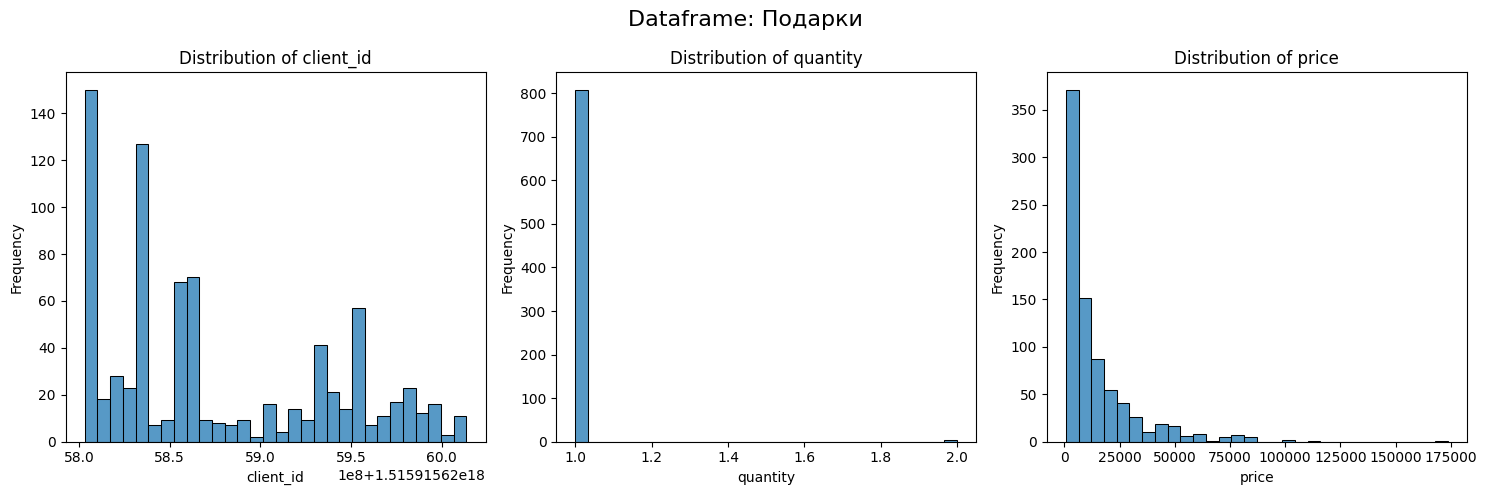

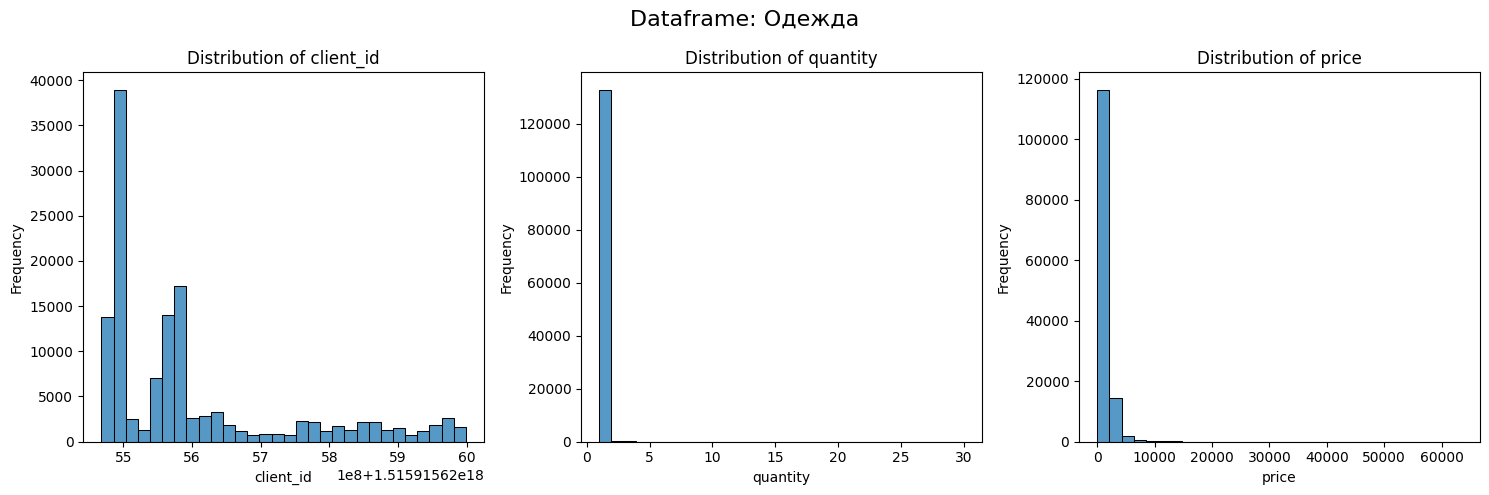

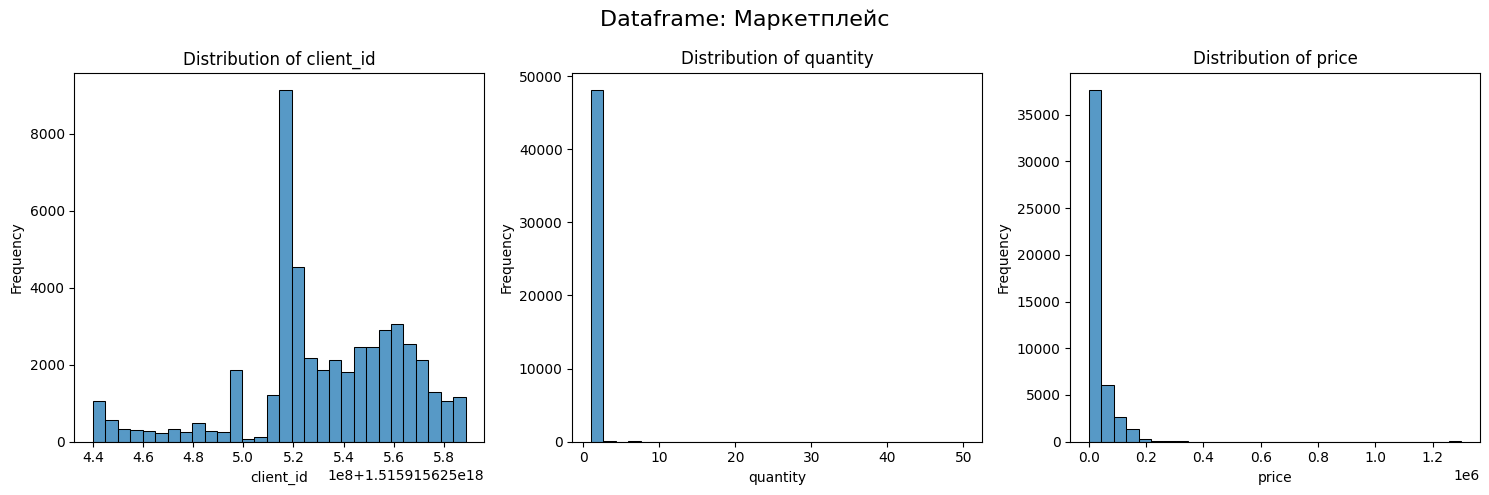

In [9]:
def plot_numeric_distribution(dataframes, bins=10):
    """
    Функция строит гистограммы распределения числовых значений в нескольких датафреймах.

    Аргументы:
    dataframes (list): Список датафреймов Pandas, содержащих числовые данные.
    bins (int, optional): Количество бинов для гистограммы.

    Возвращает:
    None: Функция выводит гистограммы распределения числовых значений.

    """
    for idx, df in enumerate(dataframes):
        # извлечем список числовых колонок
        numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

        # определим количество строк и столбцов для размещения графиков
        num_plots = len(numeric_columns)
        num_cols = 3
        num_rows = (num_plots // num_cols) + (num_plots % num_cols)

        # создадим графики
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

        # приведем axes к одномерному массиву, если он имеет одну строку
        if num_rows == 1:
            axes = axes.reshape(1, -1)

        # пройдем по каждой числовой колонке и строим график распределения
        for i, col in enumerate(numeric_columns):
            row = i // num_cols
            col = i % num_cols
            sns.histplot(df[numeric_columns[i]], bins=bins, ax=axes[row][col])
            axes[row][col].set_title(f'Distribution of {numeric_columns[i]}')
            axes[row][col].set_xlabel(numeric_columns[i])
            axes[row][col].set_ylabel('Frequency')

        # если количество графиков меньше максимального, скрываем ненужные области
        for i in range(len(numeric_columns), num_rows*num_cols):
            fig.delaxes(axes.flatten()[i])

        # добавляем явное обозначение датафрейма в названия строк графиков
        dataframe_name = df.name if hasattr(df, 'name') else f'Dataframe {idx+1}'
        fig.suptitle(f'Dataframe: {dataframe_name}', fontsize=16)

        plt.tight_layout()
        plt.show()

# Создаем датафреймы и добавляем атрибут name
df_gifts.name = "Подарки"
df_apparel.name = "Одежда"
df_marketplace.name = "Маркетплейс"

# запустим функцию
plot_numeric_distribution(dataframes, bins=30)




## 2.4 Описание данных, в контексте задачи.

***Магазин подарков.***

Датасет df_gifts  
 Исходный размер: 811*6 Количество (quantity) от 1 до 2, цена (price) от 656 до 173586, период полученных данных от 2022-10-26 по 2023-10-24. Количество пропусков 0, количество дубликатов 56. Количество уникальных клиентов 326. Соотношение числа строк к количеству клиентов: 811/326 = 2,48.  
  Предсказание повторной покупки в представленном магазине подарков при помощи модели машинного обучения выглядит малоперспективной задачей. Чтобы выделится на рынке в данном сегменте магазинов, необходимо подбирать ассортимент очень тщательно, для того чтобы строго соответствовать выбранной нише. С одной стороны, это позволит держать фокус на определенной целевой аудитории, в этом случае можно работать с относительно невысоким уровнем конкуренции с разумным рекламным бюджетом, без опасения сталкиваться на рынке с большими игроками. С другой стороны, это явное ограничение ассортимента и круга своих покупателей. Так же сама концепция магазина, подразумевает не частые покупки, так как подарки мы дарим не каждый день, а особенные подарки тем более. Судя по средней стоимости подарка 14468 рублей, это явно магазин каких-то элитных подарков, что может сильно ограничивать необходимость в повторной покупке. Мы видим эту ситуацию в цифрах за год в данных 811 записей, причем, когда мы будем производить агрегацию по покупателю, скорее всего количество сильно уменьшится.


***Магазин одежды.***

Датасет df_apparel  
 Исходный размер: 133104*6 Количество (quantity) от 1 до 30, цена (price) от 1 до 63499, период полученных данных от 2022-10-26 по 2023-10-26. Количество пропусков 0, количество дубликатов 59250. Количество уникальных клиентов 28891. Соотношение числа строк к количеству клиентов: 133104/28891 = 4,6.  
 В случае магазина одежды, предположительно, исторические данные могут дать более существенную предсказательную силу. Например, если это монобрендовый магазин, то возможно у клиентов формируется некая приверженность и доверие. Данных существенно больше, скорее всего модель будет построить проще, чем в случае с магазином подарков. Настораживает низкий средний чек в исходных данных: 1110.


***Маркетплейс.***

Датасет df_marketplace  
 Исходный размер: 48182*6 Количество (quantity) от 1 до 50, цена (price) от 0 до 1299998, период полученных данных от 2023-10-26 по 2023-10-26. Количество пропусков 0, количество дубликатов 2159. Количество уникальных клиентов 17787. Соотношение числа строк к количеству клиентов: 48182/17787 = 2,7.  

# 3 Предобработка и анализ данных

## 3.1 Расчет основных метрик

Распределение среднего количества предметов в покупке

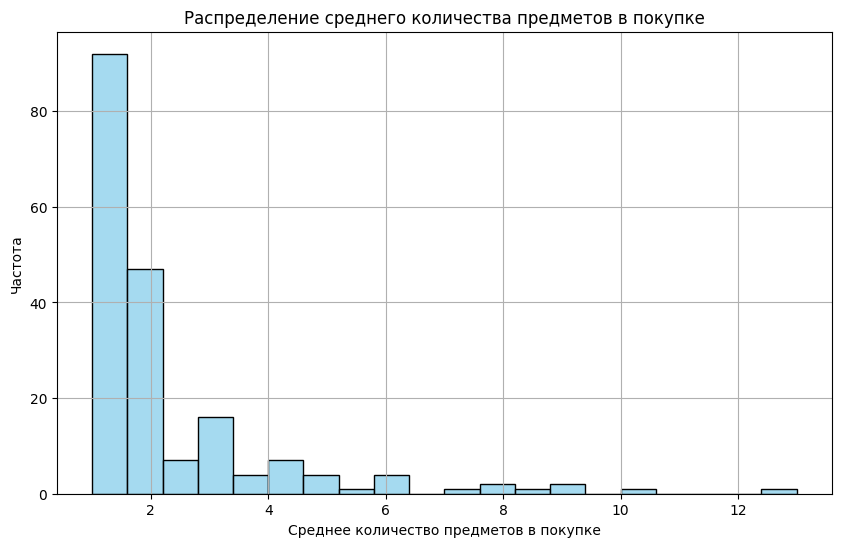

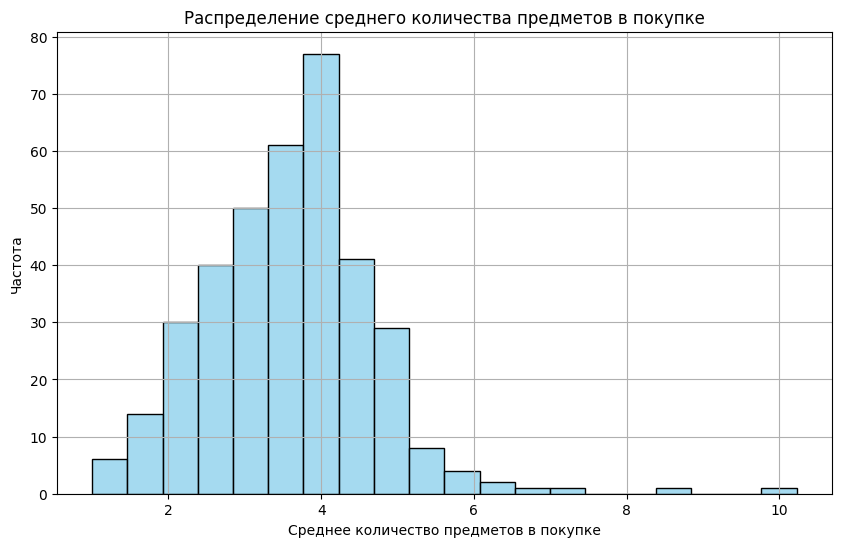

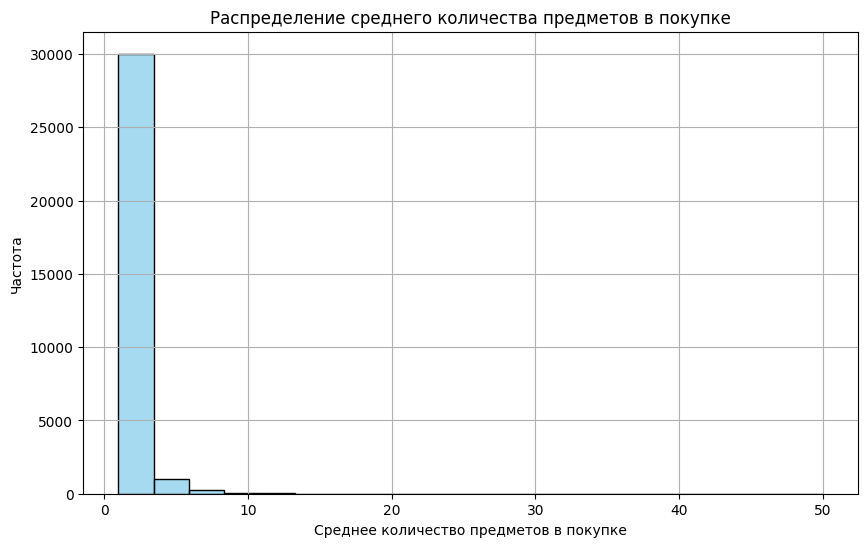

In [10]:
def plot_avg_items_per_purchase_per_day(*dfs):
    """
    Функция для построения гистограммы, отображающей распределение среднего количества предметов в покупке по дням.

    Параметры:
    *dfs (DataFrame): Переменное количество датафреймов Pandas. Каждый датафрейм содержит информацию о покупках.

    Возвращает:
    None
    """
    for df in dfs:
        # преобразуем столбец 'date' к типу данных datetime
        df['date'] = pd.to_datetime(df['date'])

        # проведем группировку данных по дате и идентификатору клиента, суммирование количества предметов
        grouped_data = df.groupby(['date', 'client_id'])['quantity'].sum().reset_index()

        # вычислим среднее количество предметов в покупке для каждой даты
        avg_items_per_purchase_per_day = grouped_data.groupby('date')['quantity'].mean().reset_index()

        # проведем сортировку результатов в порядке возрастания среднего количества предметов в покупке
        avg_items_per_purchase_per_day_sorted = avg_items_per_purchase_per_day.sort_values(by='quantity', ascending=True)

        # выведем гистограмму
        plt.figure(figsize=(10, 6))
        sns.histplot(data=avg_items_per_purchase_per_day_sorted, x='quantity', bins=20, color='skyblue', edgecolor='black')
        plt.title(f'Распределение среднего количества предметов в покупке')
        plt.xlabel('Среднее количество предметов в покупке')
        plt.ylabel('Частота')
        plt.grid(True)

    plt.show()

plot_avg_items_per_purchase_per_day(df_gifts, df_apparel, df_marketplace)

В основном во всех магазинах чаще всего приобретают по одному товару. Однако есть свои особенности:
- в магазине подарков изредка приобретают от 8-12 одинаковых предметов. На первый взгляд это не обычно. Но возможно это связано с покупкой подарков, например для корпоративных клиентов;
- в магазине одежды чаще всего приобретают 4 одинаковых предмета. Над этим нужно подумать;
- в маркетплейсе есть случаи покупки 50 одинаковых товаров, что тоже выглядит странно

Для общего понимания масштабов магазинов и их ключевых показателей сравним выручку магазинов за год, средний чек в магазине, количество уникальных покупателей.

In [11]:
# для датафрейма df_gifts
unique_clients_df_gifts = df_gifts['client_id'].nunique()
print("Количество уникальных client_id в датафрейме df_gifts:", unique_clients_df_gifts)

# для датафрейма df_apparel
unique_clients_df_apparel = df_apparel['client_id'].nunique()
print("Количество уникальных client_id в датафрейме df_apparel:", unique_clients_df_apparel)

# для датафрейма df_marketplace
unique_clients_df_marketplace = df_marketplace['client_id'].nunique()
print("Количество уникальных client_id в датафрейме df_marketplace:", unique_clients_df_marketplace)

Количество уникальных client_id в датафрейме df_gifts: 326
Количество уникальных client_id в датафрейме df_apparel: 28891
Количество уникальных client_id в датафрейме df_marketplace: 17787


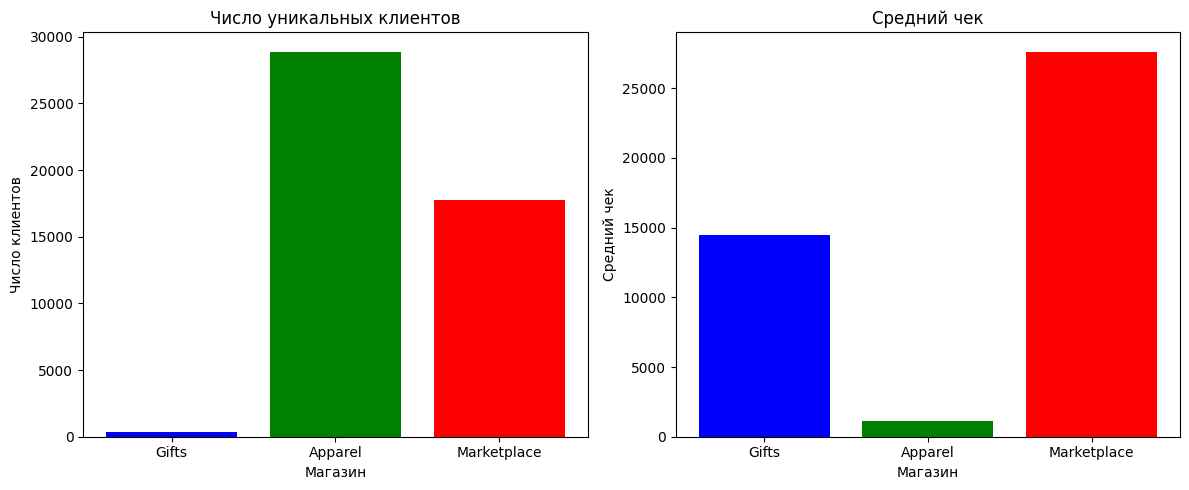

In [12]:
# число уникальных клиентов для каждого магазина
unique_clients = [unique_clients_df_gifts, unique_clients_df_apparel, unique_clients_df_marketplace]

# датафреймы и их названия
dataframes = [df_gifts, df_apparel, df_marketplace]
store_names = ['Gifts', 'Apparel', 'Marketplace']

# цвета для каждого магазина
colors = ['blue', 'green', 'red']

# произведем расчет среднего чека и среднего числа уникальных клиентов для каждого магазина
avg_checks = []
for i, df in enumerate(dataframes):
    df['total_spent'] = df['price'] * df['quantity']
    avg_checks.append(df['total_spent'].sum() / df['quantity'].sum())

# построим графики
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# график числа уникальных клиентов
axes[0].bar(store_names, unique_clients, color=colors)
axes[0].set_title('Число уникальных клиентов')
axes[0].set_xlabel('Магазин')
axes[0].set_ylabel('Число клиентов')

# график среднего чека
axes[1].bar(store_names, avg_checks, color=colors)
axes[1].set_title('Средний чек')
axes[1].set_xlabel('Магазин')
axes[1].set_ylabel('Средний чек')

plt.tight_layout()
plt.show()

Мы видим, что число клиентов очень сильно разниться. Так же отметим, что максимальный чек у маркетплейса очень большой, у одежного магазина маленький и у магазина подарков он тоже достаточно крупный. Это в первую очередь связано с ассортиментом и ценами магазина. Пока можно отметить, что магазин подарков не прост, нам это было ясно из вывода характеристик раз средняя цена его продукции около 14000 рублей. У маркетплейса большой ассортимент, и вероятно, есть очень дорогие позиции, которые сильно повышают средний показатель. Посмотрим, что покажет медианный расчет и гистограмма выручки.

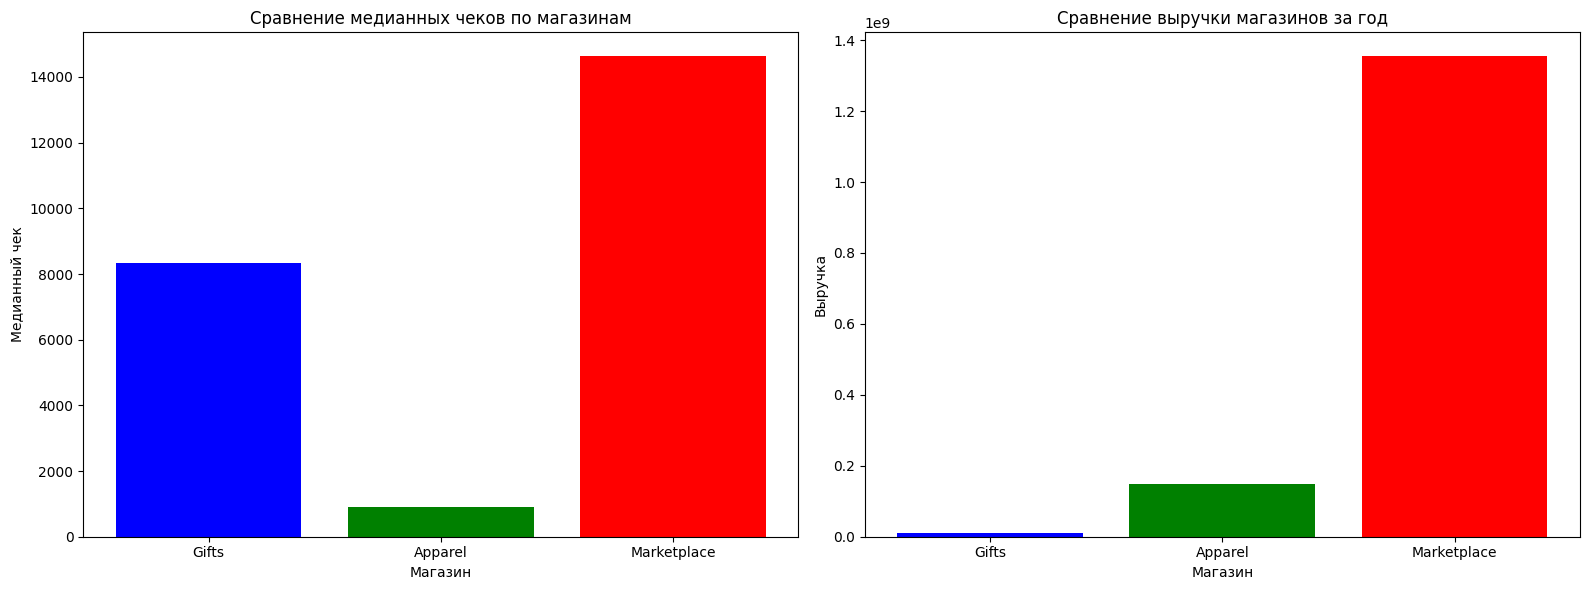

In [13]:
# создадим функцию для вычисления медианного чека для каждого магазина
def calculate_median_check(df):
    return df.groupby('date').apply(lambda x: (x['price'] * x['quantity']).median()).median()

# создадим функцию для вычисления общей выручки для каждого магазина
def calculate_revenue(df):
    return (df['price'] * df['quantity']).sum()

# создадим графики
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# сравнение медианных чеков по магазинам
axes[0].bar(store_names, [calculate_median_check(df) for df in dataframes], color=colors)
axes[0].set_title('Сравнение медианных чеков по магазинам')
axes[0].set_xlabel('Магазин')
axes[0].set_ylabel('Медианный чек')

# сравнение выручки магазинов за год
axes[1].bar(store_names, [calculate_revenue(df) for df in dataframes], color=colors)
axes[1].set_title('Сравнение выручки магазинов за год')
axes[1].set_xlabel('Магазин')
axes[1].set_ylabel('Выручка')

plt.tight_layout()
plt.show()

Мы увидели, что везде сумма чека сократилась. Причем у маркетплейса и магазина подарков очень существенно. Теперь мы понимаем, что где-то в дневных чеках есть очень существенные выбросы. Выручка так же отличается очень существенно, она логичным образом растет с ассортиментом и количеством покупателей.

Сравнивая полученные данные, можно отметить, что в представленных для анализа данных мы видим подтверждение тому, что интернет-магазины действительно сильно отличаются по клиентской базе, очень сильно отличаются по выручке. Средний чек закономерно тоже отличается, но не так существенно, как предыдущие параметры. Решающим параметром в выручке является количество клиентов и ассортимент. Но также важно сколько стоит товар, это хорошо прослеживается на сравнении продаж одежды и подарков. Количество транзакций в магазине подарков отличается в меньшую сторону в сотни раз, а выручка лишь в десятки.

## 3.2 Подготовка датафреймов

Выведем название столбцов рядом, чтобы понять, как далее можно упростить с ними работу.

In [14]:
# создадим DataFrame с названиями столбцов из каждой из трех таблиц
df_columns = pd.DataFrame({
    'df_gifts': list(df_gifts.columns)[:6],
    'df_apparel': list(df_apparel.columns)[:6],
    'df_marketplace': list(df_marketplace.columns)[:6]
})

print(df_columns)

         df_gifts      df_apparel df_marketplace
0       client_id       client_id      client_id
1        quantity        quantity       quantity
2           price           price          price
3            date            date     message_id
4      message_id      message_id     created_at
5  recommended_by  recommended_by           date


Названия столбцов client_id quantity price date message_id одинаковы, однако есть два названия, которые встречаются не везде: created_at, recommended_by.  
Изучим колонки, чтобы принять по ним решения, оставить или удалить.


In [15]:
# получим уникальные значения столбца "recommended_by" в df_gifts
unique_recommended_by = df_gifts['recommended_by'].unique()

print(unique_recommended_by)

# получим уникальные значения столбца "recommended_by" df_apparel
unique_recommended_by = df_apparel['recommended_by'].unique()

print(unique_recommended_by)

['bulk_message']
['bulk_message']


В датафреймах df_gifts, df_apparel в колонке recommended_by есть только одно значение: 'bulk_message'. Даже нет пропусков. Следовательно мы не сможем использовать эту колонку как признак, ведь значение неизменно и для покупателей, которые вернулись и для тех кото купил один раз. Можно удалить этот столбец.

***Изучим даты в таблице df_marketplace***

Поскольку даты в обеих колонках идентичны то можно от одной избавится.

По условиям задачи известно, что message_id содержит идентификатор рассылки. Но данных нам по этим рассылкам не предоставлено и сообщено, что задача построения модели, с учетом маркетинговых рассылок будет поставлена позже. Поэтому данный столбец тоже удалим.

In [16]:
def remove_columns(df, columns_to_remove):
    """
    Функция для удаления указанных столбцов из датафрейма.

    Параметры:
    df (DataFrame): Датафрейм Pandas, из которого нужно удалить столбцы.
    columns_to_remove (list): Список имен столбцов, которые необходимо удалить.

    Возвращает:
    None. Изменяет переданный датафрейм df, удаляя указанные столбцы.
    """
    df.drop(columns=columns_to_remove, inplace=True)

# список столбцов для удаления
columns_to_remove_gifts = ['message_id', 'recommended_by']
columns_to_remove_apparel = ['message_id', 'recommended_by']
columns_to_remove_marketplace = ['message_id', 'created_at']

# применим функцию к df_gifts
remove_columns(df_gifts, columns_to_remove_gifts)

# применим для df_apparel и df_marketplace
remove_columns(df_apparel, columns_to_remove_apparel)
remove_columns(df_marketplace, columns_to_remove_marketplace)

Выведем названия колонок повторно

In [17]:
# создадим DataFrame с названиями столбцов
df_columns = pd.DataFrame({
    'df_gifts': list(df_gifts.columns)[:4],
    'df_apparel': list(df_apparel.columns)[:4],
    'df_marketplace': list(df_marketplace.columns)[:4]
})

print(df_columns)

    df_gifts df_apparel df_marketplace
0  client_id  client_id      client_id
1   quantity   quantity       quantity
2      price      price          price
3       date       date           date


Все названия одинаковы, теперь с ними будет удобно работать. Посмотрим на данные в наших таблицах.

In [18]:
# для df_gifts
print("DataFrame df_gifts:")
print(df_gifts.head(2))
print("\n" + "_"*40)

# для df_apparel
print("DataFrame df_apparel:")
print(df_apparel.head(2))
print("\n" + "_"*40)

# для df_marketplace
print("DataFrame df_marketplace:")
print(df_marketplace.head(2))
print("\n" + "_"*40)

print("\nТипы данных в таблице df_gifts:")
print(df_gifts.dtypes)

print("\nТипы данных в таблице df_apparel:")
print(df_apparel.dtypes)

print("\nТипы данных в таблице df_marketplace:")
print(df_marketplace.dtypes)


DataFrame df_gifts:
             client_id  quantity    price       date  total_spent
0  1515915625803894158         1   8943.0 2023-10-11       8943.0
1  1515915625803894158         1  46369.0 2023-10-11      46369.0

________________________________________
DataFrame df_apparel:
             client_id  quantity   price       date  total_spent
0  1515915625468068833         1  3499.0 2023-09-08       3499.0
1  1515915625468068833         1  3499.0 2023-09-08       3499.0

________________________________________
DataFrame df_marketplace:
             client_id  quantity   price                date  total_spent
0  1515915625440944408         1  6298.0 2023-05-02 08:49:57       6298.0
1  1515915625440992498         1  7318.0 2023-05-22 13:52:13       7318.0

________________________________________

Типы данных в таблице df_gifts:
client_id               int64
quantity                int64
price                 float64
date           datetime64[ns]
total_spent           float64
dtype: o

Преобразуем дату со временем в простую дату, так как для решения задачи повторной покупки, часы и минуты не будут играть роли, мы все равно агрегируем дневные покупки в одну.

In [19]:
# извлечем только дату из столбца 'date' и сохраним ее обратно в этот столбец
df_marketplace['date'] = df_marketplace['date'].dt.date

print(df_marketplace.head())

# возвратим дате правильный формат
# df_marketplace = df_marketplace.assign(date=pd.to_datetime(df_marketplace['date']))

# print(df_marketplace.head())

             client_id  quantity    price        date  total_spent
0  1515915625440944408         1   6298.0  2023-05-02       6298.0
1  1515915625440992498         1   7318.0  2023-05-22       7318.0
2  1515915625441026424         1  65798.0  2023-05-17      65798.0
3  1515915625441118180         1   5598.0  2023-05-23       5598.0
4  1515915625441124500         1  77998.0  2023-05-25      77998.0


## 3.3 Проверка датафреймов на аномалии

Аномалии мы можем увидеть в количестве или цене. Выведем соответствующие графики.

In [20]:
def check_anomalies(df):
    """
    Функция для проверки наличия аномалий в датафрейме по колонкам 'quantity' и 'price'.

    Параметры:
    df (DataFrame): Датафрейм Pandas, который необходимо проверить на аномалии.

    Возвращает:
    quantity_anomalies (DataFrame): Датафрейм, содержащий строки с аномальными значениями в колонке 'quantity'.
    price_anomalies (DataFrame): Датафрейм, содержащий строки с аномальными значениями в колонке 'price'.
    """
    # определим границы для аномалий используя стандартное отклонение
    std_quantity = df['quantity'].std()
    mean_quantity = df['quantity'].mean()
    std_price = df['price'].std()
    mean_price = df['price'].mean()

    # выявим аномалии в количестве
    quantity_anomalies = df[(df['quantity'] < mean_quantity - 3 * std_quantity) | (df['quantity'] > mean_quantity + 3 * std_quantity)]

    # выявим аномалии в ценах
    price_anomalies = df[(df['price'] < mean_price - 3 * std_price) | (df['price'] > mean_price + 3 * std_price)]

    return quantity_anomalies, price_anomalies

# проверим аномалии для каждого датафрейма
gifts_quantity_anomalies, gifts_price_anomalies = check_anomalies(df_gifts)
apparel_quantity_anomalies, apparel_price_anomalies = check_anomalies(df_apparel)
marketplace_quantity_anomalies, marketplace_price_anomalies = check_anomalies(df_marketplace)

print("Аномалии в колонке 'quantity' для df_gifts:")
print(gifts_quantity_anomalies)
print("\nАномалии в колонке 'price' для df_gifts:")
print(gifts_price_anomalies)

print("\nАномалии в колонке 'quantity' для df_apparel:")
print(apparel_quantity_anomalies)
print("\nАномалии в колонке 'price' для df_apparel:")
print(apparel_price_anomalies)

print("\nАномалии в колонке 'quantity' для df_marketplace:")
print(marketplace_quantity_anomalies)
print("\nАномалии в колонке 'price' для df_marketplace:")
print(marketplace_price_anomalies)


Аномалии в колонке 'quantity' для df_gifts:
               client_id  quantity   price       date  total_spent
461  1515915625904297500         2   656.0 2023-01-31       1312.0
529  1515915625919399878         2  7830.0 2023-02-15      15660.0
557  1515915625803892965         2  7781.0 2023-06-12      15562.0

Аномалии в колонке 'price' для df_gifts:
               client_id  quantity     price       date  total_spent
12   1515915625803894158         1   73344.0 2023-10-11      73344.0
29   1515915625835005573         1  110556.0 2023-10-02     110556.0
71   1515915625803894158         1   74091.0 2023-07-24      74091.0
113  1515915625856252097         1   81490.0 2023-07-01      81490.0
118  1515915625860409683         1   81490.0 2023-07-01      81490.0
167  1515915625984601209         1   74971.0 2023-07-01      74971.0
183  1515915625861627387         1   86351.0 2023-09-22      86351.0
199  1515915625990584920         1  101286.0 2023-09-07     101286.0
342  1515915625936109801 

Поскольку у нас совсем нет данных по товарам то ни одна из цифр, статистически подходящая под аномалию не может по факту ей является. Все значения не выходят за рамки стоимости товаров в интернет-магазинах. Пусть даже некоторые цены кажутся дорогими. Тоже самое можно сказать о количестве товаров. Можно лишь отметить, что нормой для магазинов подарков и одежды является продажа товара в единичном экземпляре, а для маркетплейса 1-2, все другие значения редки. Аномалии, вероятно, мы увидим в анализе продаж по конкретным клиентам.

Удалим строки с нулевой ценой в колонке 'price' датафрейма df_marketplace, это единственное, что подходит под аномалию в данный момент. Возможно, эта позиция шла в подарок, или это какая-нибудь клубная карта.

In [21]:
# отфильтруем строки с нулевым значением в колонке 'price' чтобы понять сколько будет таких строк
df_with_zero_price = df_marketplace[df_marketplace['price'] == 0]

# выведем результат
print(df_with_zero_price)

# можно удалять
df_marketplace = df_marketplace[df_marketplace['price'] != 0]

print()
pd.set_option('display.max_rows', None)
display(df_marketplace.describe())
pd.reset_option('display.max_rows')


                 client_id  quantity  price        date  total_spent
32019  1515915625520674208         1    0.0  2023-08-23          0.0
32020  1515915625520674208         1    0.0  2023-08-23          0.0



,client_id,quantity,price,total_spent
count,4.818000e+04,48180.000000,4.818000e+04,4.818000e+04
mean,1.515916e+18,1.017414,2.792011e+04,2.810806e+04
std,3.173444e+07,0.540603,4.492331e+04,4.572587e+04
min,1.515916e+18,1.000000,1.000000e+00,1.000000e+00
25%,1.515916e+18,1.000000,1.205000e+03,1.230500e+03
50%,1.515916e+18,1.000000,9.998000e+03,9.998000e+03
75%,1.515916e+18,1.000000,3.599800e+04,3.599800e+04
max,1.515916e+18,50.000000,1.299998e+06,1.407872e+06


## 3.4 Обработка дубликатов

Начнем с магазина подарков. У него количество записей в данных 811, а дубликатов было 59. Что могут означать эти повторные записи? Может ли быть какое что какое-то число клиентов в тот же день купило повторно тот же товар? Да такое возможно. Посмотрим на данные, возможно, что ни будь увидим.

In [22]:
# дубликаты
duplicates = df_gifts[df_gifts.duplicated(keep=False)]

print(duplicates)

               client_id  quantity    price       date  total_spent
13   1515915625803894158         1  14802.0 2023-10-11      14802.0
14   1515915625803894158         1  14802.0 2023-10-11      14802.0
15   1515915625803894158         1   6778.0 2023-10-11       6778.0
16   1515915625803894158         1   6778.0 2023-10-11       6778.0
19   1515915625803894158         1   5790.0 2023-10-11       5790.0
..                   ...       ...      ...        ...          ...
795  1515915625862783809         1   5194.0 2022-11-08       5194.0
797  1515915625864817073         1   1893.0 2022-11-11       1893.0
798  1515915625864817073         1   1893.0 2022-11-11       1893.0
807  1515915625873498326         1   3035.0 2022-11-23       3035.0
808  1515915625873498326         1   3035.0 2022-11-23       3035.0

[89 rows x 5 columns]


Мы ничего не видим специфического. Просто имеем повторы строк, с одинаковыми днями в разных месяцах в разных годах. Процент не большой 56/(811/100) = 6,9%. К сожалению, мне не удалось узнать у заказчика есть ли возможность отличить реальные повторные покупки, от ошибок записи.


Проведем изучение дубликатов оставшихся датафреймов

In [23]:
# дубликаты
duplicates = df_apparel[df_apparel.duplicated(keep=False)]

print(duplicates)

                  client_id  quantity   price       date  total_spent
0       1515915625468068833         1  3499.0 2023-09-08       3499.0
1       1515915625468068833         1  3499.0 2023-09-08       3499.0
2       1515915625468068833         1  3499.0 2023-09-08       3499.0
3       1515915625468068833         1  2450.0 2023-09-08       2450.0
4       1515915625468068833         1  2450.0 2023-09-08       2450.0
...                     ...       ...     ...        ...          ...
133090  1515915625909141235         1   399.0 2022-12-30        399.0
133099  1515915625909375164         1  2399.0 2022-12-31       2399.0
133100  1515915625909375164         1  2399.0 2022-12-31       2399.0
133101  1515915625909375164         1  1699.0 2022-12-31       1699.0
133102  1515915625909375164         1  1699.0 2022-12-31       1699.0

[102282 rows x 5 columns]


В датасете df_apparel, ситуация на первый взгляд не обычная, например для client_id 1515915625468068833 мы имеем 3 повторения за день. Получается, что клиент в один день приобретает 3 вещи по одной цене. Это объясняет почему мы в самом начале исследуя характеристики данных столкнулись с показателем соотношения количества строк датафрейма к количеству уникальных клиентов: 133104/28891 = 4,6.
Так как это магазин одежды мы выдвигаем гипотезу о том, что это просто, приобретается одна и таже вещь, разной расцветки или размера. На интернет-рынке одежды, это сейчас распространенная практика. Во многих магазинах вещи, которые не подошли просто возвращают. Это позволяет конкурировать с другими магазинами и поддерживать лояльность аудитории. Расходы на возвраты "вшиты" в бизнес-модель таких компаний.

In [24]:
# дубликаты
duplicates = df_marketplace[df_marketplace.duplicated(keep=False)]

print(duplicates)

                 client_id  quantity    price        date  total_spent
23     1515915625442077093         1  34998.0  2023-05-15      34998.0
24     1515915625442077093         1  34998.0  2023-05-15      34998.0
26     1515915625442077093         1  34998.0  2023-05-15      34998.0
36     1515915625443176973         1  37998.0  2023-05-16      37998.0
37     1515915625443176973         1  37998.0  2023-05-16      37998.0
...                    ...       ...      ...         ...          ...
48160  1515915625575644960         1  57998.0  2023-04-27      57998.0
48177  1515915625575803144         1  29998.0  2023-04-29      29998.0
48178  1515915625575803144         1  29998.0  2023-04-29      29998.0
48180  1515915625575809442         1  15998.0  2023-04-29      15998.0
48181  1515915625575809442         1  15998.0  2023-04-29      15998.0

[14731 rows x 5 columns]


В маркетплейсе ассортимент очень большой и мы предположим, что в данном случае, ситуация будет комбинацией из первых двух.  
В результате проведенного анализа я принимаю решение не удалять дубли из датасетов. Просто, мы будем иметь эту особенность данных ввиду, и донесем ее до специалистов заказчика, которые предоставили нам данные.

## 3.5 Анализ продаж по месяцам

Хотелось бы посмотреть, как распределен объем выручки по месяцам в представленных данных. Добавим колонки для промежуточного анализа: год с месяцем (year_month) и сумма покупки за месяц (sum_month).

In [25]:
# преобразуем столбец 'date' в формат datetime
df_gifts = df_gifts.copy()
df_apparel = df_apparel.copy()
df_marketplace = df_marketplace.copy()

df_gifts['date'] = pd.to_datetime(df_gifts['date'])
df_apparel['date'] = pd.to_datetime(df_apparel['date'])
df_marketplace['date'] = pd.to_datetime(df_marketplace['date'])

# добавим столбец с годом и месяцем
df_gifts['year_month'] = df_gifts['date'].dt.to_period('M')
df_apparel['year_month'] = df_apparel['date'].dt.to_period('M')
df_marketplace['year_month'] = df_marketplace['date'].dt.to_period('M')

# добавим колонку суммы продаж в месяц (sum_month)
df_gifts['sum_month'] = df_gifts.groupby('year_month')['total_spent'].transform('sum')
df_apparel['sum_month'] = df_apparel.groupby('year_month')['total_spent'].transform('sum')
df_marketplace['sum_month'] = df_marketplace.groupby('year_month')['total_spent'].transform('sum')

print("DataFrame df_gifts с новыми колонками:")
display(df_gifts)
print("\nDataFrame df_apparel с новыми колонками:")
display(df_apparel.head())
print("\nDataFrame df_marketplace с новыми колонками:")
display(df_marketplace.head())

print("Размер данных в датафрейме df_gifts:", df_gifts.shape)


DataFrame df_gifts с новыми колонками:


,client_id,quantity,price,date,total_spent,year_month,sum_month
0,1515915625803894158,1,8943.0,2023-10-11,8943.0,2023-10,950586.0
1,1515915625803894158,1,46369.0,2023-10-11,46369.0,2023-10,950586.0
2,1515915625803894158,1,4666.0,2023-10-11,4666.0,2023-10,950586.0
3,1515915625803894158,1,11963.0,2023-10-11,11963.0,2023-10,950586.0
4,1515915625803894158,1,13107.0,2023-10-11,13107.0,2023-10,950586.0
...,...,...,...,...,...,...,...
806,1515915625870025628,1,39992.0,2022-11-28,39992.0,2022-11,1444913.0
807,1515915625873498326,1,3035.0,2022-11-23,3035.0,2022-11,1444913.0
808,1515915625873498326,1,3035.0,2022-11-23,3035.0,2022-11,1444913.0
809,1515915625878133961,1,3442.0,2022-11-26,3442.0,2022-11,1444913.0



DataFrame df_apparel с новыми колонками:


,client_id,quantity,price,date,total_spent,year_month,sum_month
0,1515915625468068833,1,3499.0,2023-09-08,3499.0,2023-09,6091988.0
1,1515915625468068833,1,3499.0,2023-09-08,3499.0,2023-09,6091988.0
2,1515915625468068833,1,3499.0,2023-09-08,3499.0,2023-09,6091988.0
3,1515915625468068833,1,2450.0,2023-09-08,2450.0,2023-09,6091988.0
4,1515915625468068833,1,2450.0,2023-09-08,2450.0,2023-09,6091988.0



DataFrame df_marketplace с новыми колонками:


,client_id,quantity,price,date,total_spent,year_month,sum_month
0,1515915625440944408,1,6298.0,2023-05-02,6298.0,2023-05,127218272.0
1,1515915625440992498,1,7318.0,2023-05-22,7318.0,2023-05,127218272.0
2,1515915625441026424,1,65798.0,2023-05-17,65798.0,2023-05,127218272.0
3,1515915625441118180,1,5598.0,2023-05-23,5598.0,2023-05,127218272.0
4,1515915625441124500,1,77998.0,2023-05-25,77998.0,2023-05,127218272.0


Размер данных в датафрейме df_gifts: (811, 7)


Создадим новые таблицы для вывода графиков распределения выручки.

In [26]:
# создадим новые таблицы с первой строкой из каждого месяца
revenue_by_month_gifts = df_gifts.groupby('year_month', as_index=False).first()[['year_month', 'sum_month']]
revenue_by_month_apparel = df_apparel.groupby('year_month', as_index=False).first()[['year_month', 'sum_month']]
revenue_by_month_marketplace = df_marketplace.groupby('year_month', as_index=False).first()[['year_month', 'sum_month']]

# выведем результат для revenue_by_month_gifts
print("DataFrame revenue_by_month_gifts:")
display(revenue_by_month_gifts.head())
print("\nТипы данных в таблице revenue_by_month_gifts:")
display(revenue_by_month_gifts.dtypes)

# выведем результат для revenue_by_month_apparel
print("\nDataFrame revenue_by_month_apparel:")
display(revenue_by_month_apparel.head())
print("\nТипы данных в таблице revenue_by_month_apparel:")
display(revenue_by_month_apparel.dtypes)

# выведем результат для revenue_by_month_apparel
print("\nDataFrame revenue_by_month_marketplace:")
display(revenue_by_month_marketplace.head())
print("\nТипы данных в таблице revenue_by_month_marketplace:")
display(revenue_by_month_marketplace.dtypes)

DataFrame revenue_by_month_gifts:


,year_month,sum_month
0,2022-10,179589.0
1,2022-11,1444913.0
2,2022-12,334257.0
3,2023-01,984946.0
4,2023-02,576171.0



Типы данных в таблице revenue_by_month_gifts:


year_month    period[M]
sum_month       float64
dtype: object


DataFrame revenue_by_month_apparel:


,year_month,sum_month
0,2022-10,210954.0
1,2022-11,24638364.0
2,2022-12,22174933.0
3,2023-01,3538139.0
4,2023-02,2252425.0



Типы данных в таблице revenue_by_month_apparel:


year_month    period[M]
sum_month       float64
dtype: object


DataFrame revenue_by_month_marketplace:


,year_month,sum_month
0,2022-10,3201253.0
1,2022-11,136730547.0
2,2022-12,78191642.0
3,2023-01,64991478.0
4,2023-02,180836233.0



Типы данных в таблице revenue_by_month_marketplace:


year_month    period[M]
sum_month       float64
dtype: object

Построим графики для анализа выручки магазинов

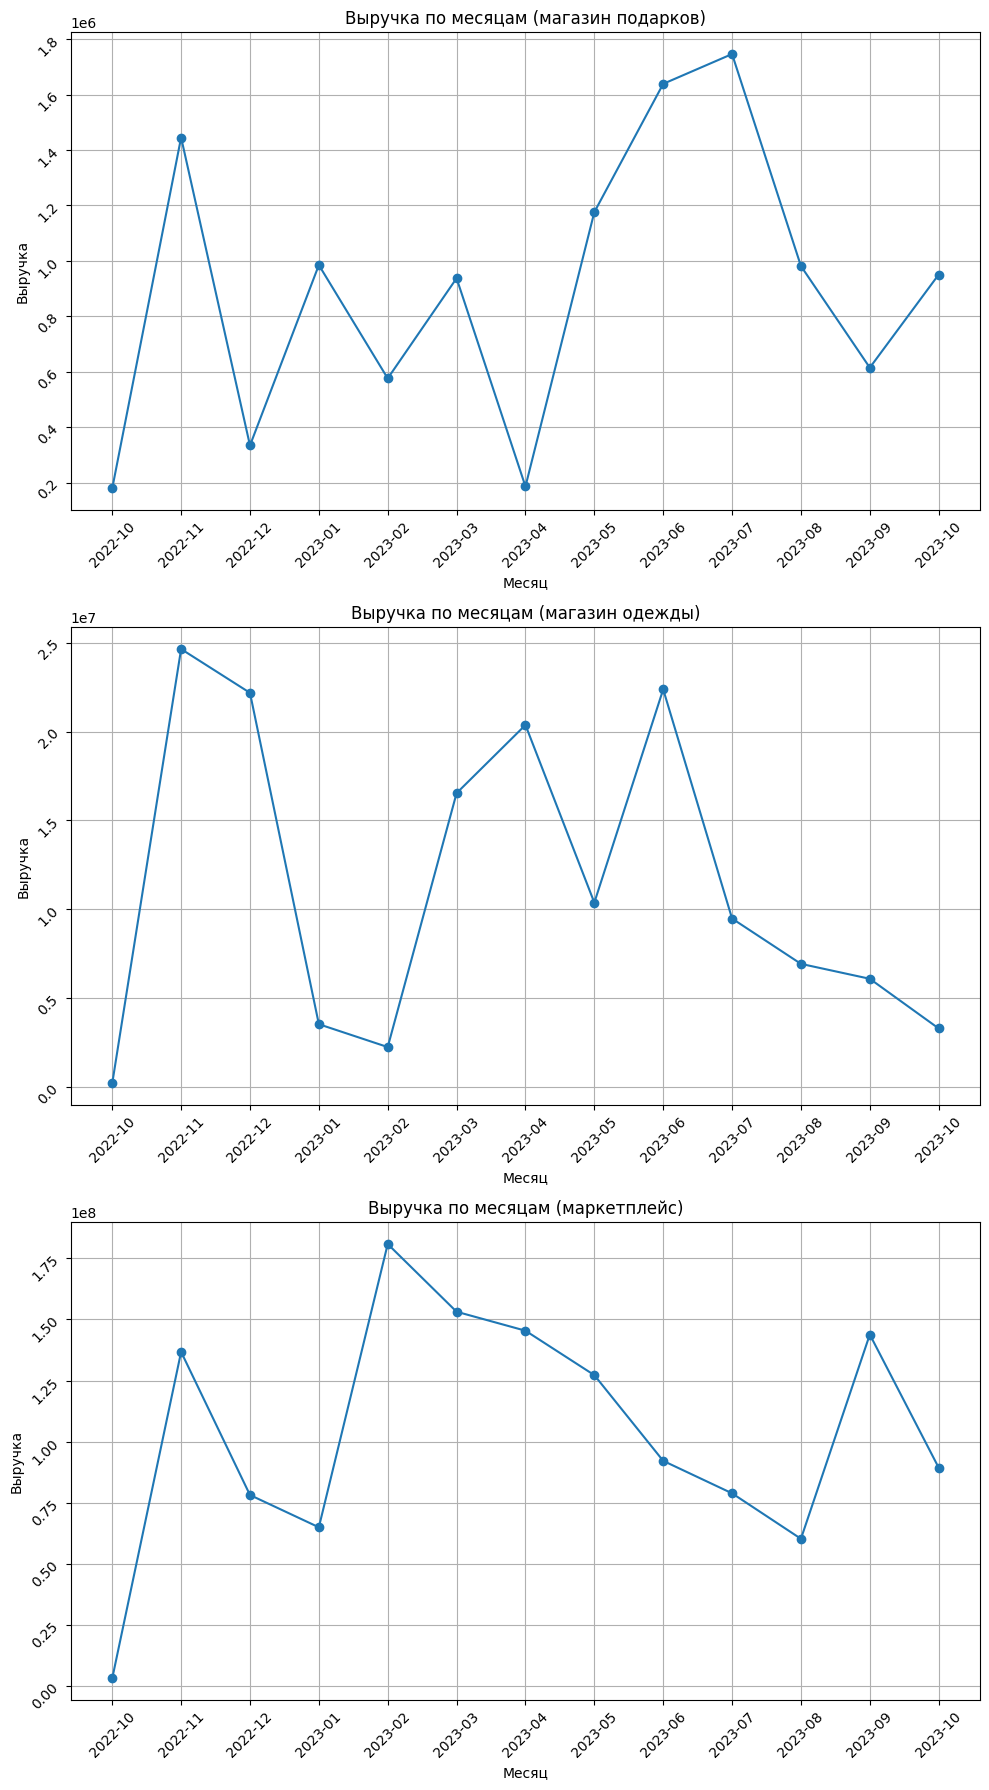

In [27]:
# преобразуем столбец year_month в строковый формат для каждого датафрейма
revenue_by_month_gifts['year_month'] = revenue_by_month_gifts['year_month'].astype(str)
revenue_by_month_apparel['year_month'] = revenue_by_month_apparel['year_month'].astype(str)
revenue_by_month_marketplace['year_month'] = revenue_by_month_marketplace['year_month'].astype(str)

# создадим новую фигуру и подграфики
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# график для revenue_by_month_gifts
axs[0].plot(revenue_by_month_gifts['year_month'], revenue_by_month_gifts['sum_month'], marker='o')
axs[0].set_title('Выручка по месяцам (магазин подарков)')
axs[0].set_xlabel('Месяц')
axs[0].set_ylabel('Выручка')
axs[0].grid(True)
axs[0].tick_params(rotation=45)

# график для revenue_by_month_apparel
axs[1].plot(revenue_by_month_apparel['year_month'], revenue_by_month_apparel['sum_month'], marker='o')
axs[1].set_title('Выручка по месяцам (магазин одежды)')
axs[1].set_xlabel('Месяц')
axs[1].set_ylabel('Выручка')
axs[1].grid(True)
axs[1].tick_params(rotation=45)

# график для revenue_by_month_marketplace
axs[2].plot(revenue_by_month_marketplace['year_month'], revenue_by_month_marketplace['sum_month'], marker='o')
axs[2].set_title('Выручка по месяцам (маркетплейс)')
axs[2].set_xlabel('Месяц')
axs[2].set_ylabel('Выручка')
axs[2].grid(True)
axs[2].tick_params(rotation=45)


plt.tight_layout()
plt.show()

Магазин подарков.  
Мы имеем почти пилообразный график, с выраженным предновогодним пиком, а также ростом продаж, начинающимся с конца весны и достигающего в июле максимального значения. Желательно выяснить почему выручка апреля существенно ниже средней отметки. Это не похоже на нормальную ситуацию. Если это не специфика ассортимента, то это может быть знаком отсутствия товара на складе или потери трафика.

Магазин одежды.  
В магазине одежды ярко выраженный сезонный график продаж. Выделяются 2 пика: осень-зима дает рост выручки в ноябре и декабре, весна-лето дает протяженный рост выручки с марта по июнь. После каждого роста продаж идет охлаждение интереса к товарам текущего сезона.

Маркетплейс.  
Имеется выраженный высокий ноябрьский спрос, видимо вызванный распродажами, затем декабрь и январь спад и затишье. Резкое восстановление дает максимальные продажи в феврале и затем постепенное снижение оставшиеся весенние месяцы и все лето. Затем наблюдается резкий взлет продаж в сентябре, связанный по всей видимости с концом отпускного сезона и началом учебного года. График интересный и не совсем однозначный. Не совсем понятно почему нет предновогоднего бума продаж в декабре, или почему он не удерживается хотя бы на ноябрьском уровне. И так же интересным кажется, что самым большим объемом выручки стал февраль.
В итоге мы видим, что графики всех трех магазинов имеют вполне нормальные очертания. Мы не наблюдаем в них сильных восходящих или нисходящих трендов, которые могли бы указывать на существенное изменение ситуации в деятельности магазина и тем самым сказаться на качестве построенной на этих данных модели.


### 3.5.1 Анализ продаж по клиентам магазина подарков

Проанализируем, сколько денег чаще всего в год тратят покупатели.

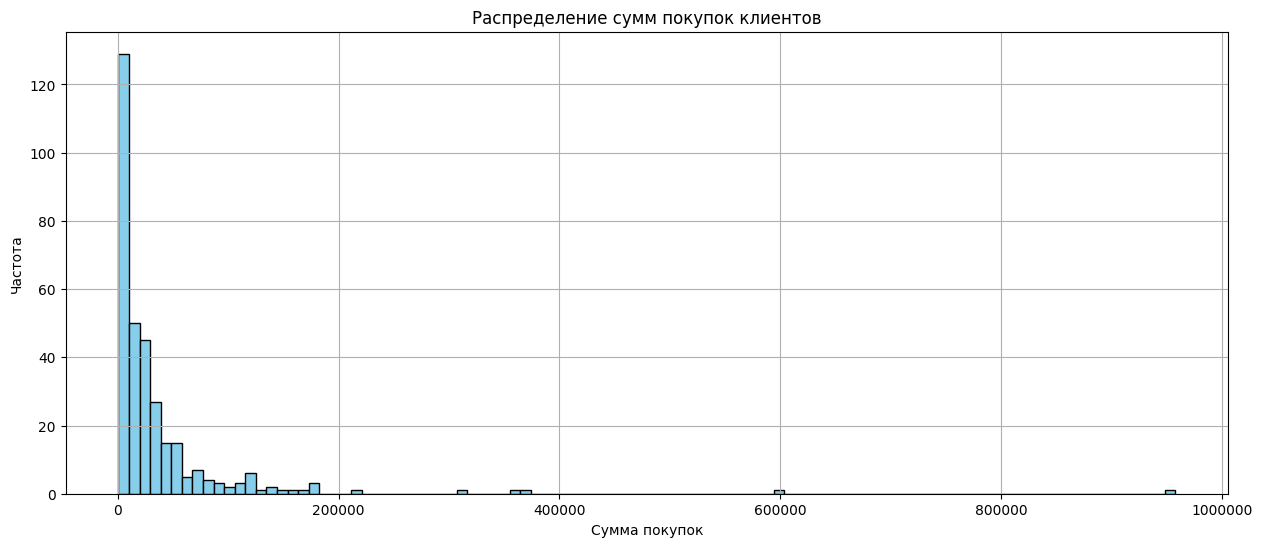

Размер данных в датафрейме df_gifts: (811, 7)


In [28]:
# проведем группировку данных по client_id и суммирование покупок
df_grouped = df_gifts.groupby('client_id')['total_spent'].sum().reset_index()

# построим гистограммы распределения сумм покупок
plt.figure(figsize=(15, 6))
plt.hist(df_grouped['total_spent'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение сумм покупок клиентов')
plt.xlabel('Сумма покупок')
plt.ylabel('Частота')
plt.ticklabel_format(style='plain', axis='x')
plt.grid(True)
plt.show()

print("Размер данных в датафрейме df_gifts:", df_gifts.shape)

Выведем отдельно таблицу с клиентами, которые покупают на сумму более 200000 в год. Посмотрим сколько их.

In [29]:
# выберем клиентов с суммой покупок более 200000
high_spending_clients = df_grouped[df_grouped['total_spent'] > 200000]


display(high_spending_clients)

,client_id,total_spent
28,1515915625803892965,602284.0
29,1515915625803894158,957950.0
56,1515915625824280360,311984.0
131,1515915625855755713,360460.0
143,1515915625858800593,371125.0
303,1515915625984601209,211681.0


Суммы внушительные, клиентов всего шесть. Посмотрим на конкретные записи из таблицы.

In [30]:
# выведем данные для конкретных клиентов
high_spending_clients_id = [1515915625803892965, 1515915625803894158, 1515915625824280360, 1515915625855755713, 1515915625858800593, 1515915625984601209]

df_filtered = df_gifts[df_gifts['client_id'].isin(high_spending_clients_id)]
display(df_filtered)

,client_id,quantity,price,date,total_spent,year_month,sum_month
0,1515915625803894158,1,8943.0,2023-10-11,8943.0,2023-10,950586.0
1,1515915625803894158,1,46369.0,2023-10-11,46369.0,2023-10,950586.0
2,1515915625803894158,1,4666.0,2023-10-11,4666.0,2023-10,950586.0
3,1515915625803894158,1,11963.0,2023-10-11,11963.0,2023-10,950586.0
4,1515915625803894158,1,13107.0,2023-10-11,13107.0,2023-10,950586.0
...,...,...,...,...,...,...,...
772,1515915625858800593,1,39990.0,2022-11-17,39990.0,2022-11,1444913.0
773,1515915625858800593,1,29393.0,2022-11-17,29393.0,2022-11,1444913.0
774,1515915625858800593,1,29393.0,2022-11-17,29393.0,2022-11,1444913.0
775,1515915625858800593,1,29993.0,2022-11-17,29993.0,2022-11,1444913.0


Клиент в один день выбирает несколько разных или одинаковых достаточно дорогих товаров. Интересно...  
Глядя на эту информацию сразу хочется узнать, а какая часть годовой выручки приходится на этих клиентов?

In [31]:
# общая годовая выручка
total_annual_revenue = df_gifts['total_spent'].sum()

# отфильтруем данные только для указанных клиентов
revenue_for_specified_clients = df_gifts[df_gifts['client_id'].isin(high_spending_clients_id)]['total_spent'].sum()

# вычислим доли выручки для указанных клиентов в процентах
revenue_ratio_percent = (revenue_for_specified_clients / total_annual_revenue)* 100

print("Доля годовой выручки, приходящейся на указанных клиентов: {:.2f}%".format(revenue_ratio_percent))

Доля годовой выручки, приходящейся на указанных клиентов: 23.96%


В магазине подарков всего 6 клиентов обеспечивают почти четверть выручки. Скорее всего это будет сильно влиять на модель. Для таких клиентов нужно сделать отдельный трекер, который бы отслеживал появление новых лидеров продаж, а также контролировал их срок жизни. Увеличение срока между продажами у таких VIP клиентов с максимальной выручкой, необходимо отслеживать и иметь возможность на него влиять.  
Конечно, нужно лучше узнать этих клиентов. Возможно, это корпоративный сектор, где для сотрудников и клиентов большой компании идет закуп подарков. Может быть, это мелкооптовые клиенты, которые берут на перепродажу. В любом случае необходимо разобраться в этом вопросе, для лучшего удовлетворения потребностей таких клиентов. И четко отслеживать их активность реагируя соответствующим образом. Скорее всего просто письмом в таких случаях ограничиваться не стоит и для подобных клиентов возможно больше подойдет общение с менеджером. Можно выделить особый сегмент и целенаправленно в нем увеличивать число покупателей.


Посмотрим на визуализацию поведения таких клиентов.

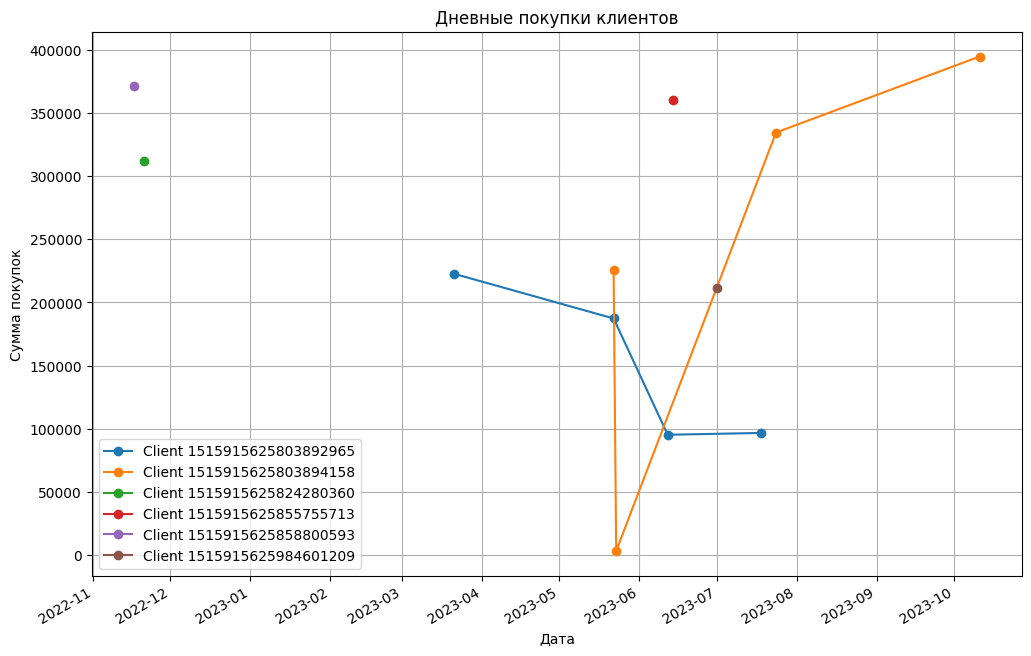

In [32]:
# клиенты для построения графиков
clients = [1515915625803892965, 1515915625803894158, 1515915625824280360, 1515915625855755713, 1515915625858800593, 1515915625984601209]

plt.figure(figsize=(12, 8))

# построим графики для каждого клиента
for client_id in clients:
    # отфильтруем данные для текущего клиента
    client_data = df_gifts[df_gifts['client_id'] == client_id]
    # сгруппируем данные по дате и суммируем сумму покупок за каждый день
    daily_purchases = client_data.groupby('date')['total_spent'].sum()
    daily_purchases.plot(marker='o', linestyle='-', label=f'Client {client_id}')

plt.legend()
plt.title('Дневные покупки клиентов')
plt.xlabel('Дата')
plt.ylabel('Сумма покупок')
plt.grid(True)


plt.show()

Двое из клиентов серьезно закупились однажды всего лишь один раз перед новым годом, что в принципе объяснимо, оставшиеся из группы в период с весны до конца лета, имели от одной до четырех покупок. В целом поведение делится на 2 траектории: либо одноразовая покупка (нужно проверять прошлые года), либо клиенты имеют покупки в разные даты и это уже более перспективная история, людям понравился магазин/товар и они готовы продолжать приобретать в нем подарки в разные даты для разных случаев, разным людям.

### 3.5.2 Анализ продаж по клиентам магазина одежды

Посмотрим какие суммы чаще всего тратят покупатели в магазине одежды

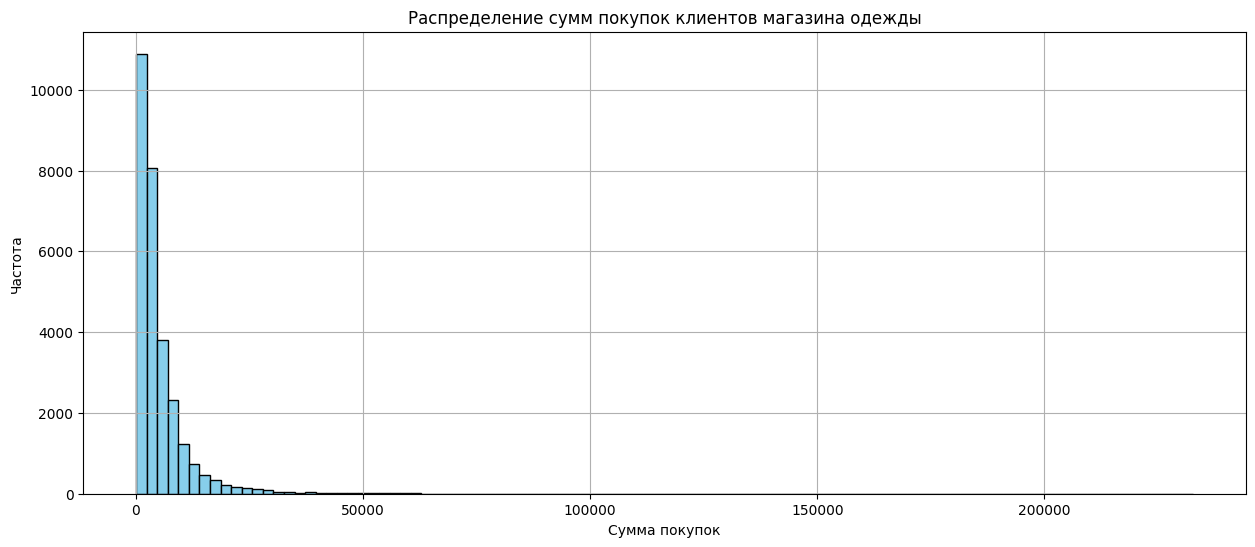

In [33]:
# группируем данные по client_id и производим суммирование покупок
df_grouped = df_apparel.groupby('client_id')['total_spent'].sum().reset_index()

# построим гистограмму распределения сумм покупок
plt.figure(figsize=(15, 6))
plt.hist(df_grouped['total_spent'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение сумм покупок клиентов магазина одежды')
plt.xlabel('Сумма покупок')
plt.ylabel('Частота')
plt.ticklabel_format(style='plain', axis='x')
plt.grid(True)
plt.show()

Выведем отдельно таблицу с клиентами, которые покупают на сумму более 100000 в год. Посмотрим сколько их.

In [34]:
# отбор клиентов с суммой покупок более 100000
high_spending_clients = df_grouped[df_grouped['total_spent'] > 100000]

display(high_spending_clients)

,client_id,total_spent
6917,1515915625490352441,103450.0
9457,1515915625500232103,162103.0
13535,1515915625557342756,126303.0
17573,1515915625580548703,138558.0
17758,1515915625581786063,110972.0
19213,1515915625589682336,113678.0
19599,1515915625590690250,101506.0
23708,1515915625776653984,164218.0
25430,1515915625853312319,232671.0
25653,1515915625860624470,116329.0


В магазине одежды мы видим небольшое число клиентов, которые визуально выбиваются за основную массу, и суммы не очень велики для того, чтобы формировать существенную часть выручки. Общая сумма лежит в пределах 2 млн рублей.

In [35]:
# общая годовая выручка
total_annual_revenue = df_apparel['total_spent'].sum()

# отфильтруем данные только для указанных клиентов
revenue_for_specified_clients = df_apparel[df_apparel['client_id'].isin(high_spending_clients_id)]['total_spent'].sum()

# вычислим долю выручки для указанных клиентов в процентах
revenue_ratio_percent = (revenue_for_specified_clients / total_annual_revenue)* 100

print("Доля годовой выручки, приходящейся на указанных клиентов: {:.2f}%".format(revenue_ratio_percent))

Доля годовой выручки, приходящейся на указанных клиентов: 0.00%


Да, сумма не велика. Теперь проверим последний датасет

### 3.5.3 Анализ продаж по клиентам маркетплейса

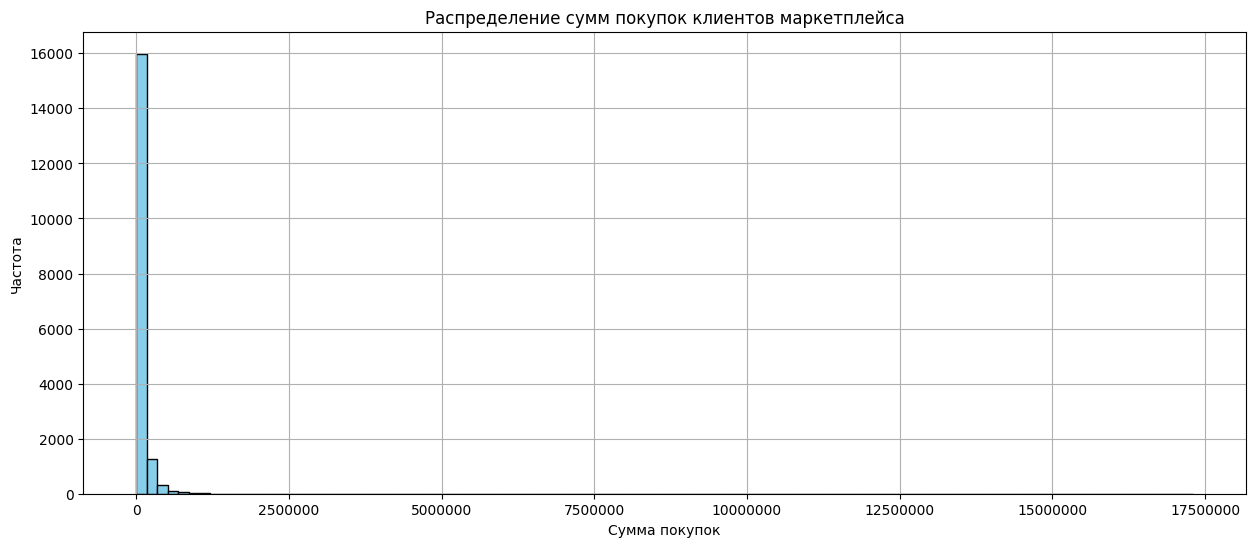

In [36]:
# Группировка данных по client_id и суммирование покупок
df_grouped = df_marketplace.groupby('client_id')['total_spent'].sum().reset_index()

# Построение гистограммы распределения сумм покупок
plt.figure(figsize=(15, 6))  # Увеличиваем ширину до 15 дюймов
plt.hist(df_grouped['total_spent'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение сумм покупок клиентов маркетплейса')
plt.xlabel('Сумма покупок')
plt.ylabel('Частота')
plt.ticklabel_format(style='plain', axis='x')  # Убираем научное представление на оси x
plt.grid(True)
plt.show()

На данном графике, можно отметить длинный "хвост" значений уходящий за 2 млн. в год. При чем максимальное значение 17,3 млн. рублей. Всего клиентов в данном диапазоне 12.

In [37]:
# отбор клиентов с суммой покупок более 200000
high_spending_clients = df_grouped[df_grouped['total_spent'] > 2000000]

display(high_spending_clients)

,client_id,total_spent
367,1515915625446481060,4695583.0
428,1515915625448676587,2153370.0
5924,1515915625518981759,15599976.0
7469,1515915625521963337,3448699.0
7550,1515915625522359185,2014290.0
10909,1515915625546197123,2098956.0
10952,1515915625546393273,6733644.0
11223,1515915625548079160,5661928.0
11374,1515915625548888939,2758180.0
12414,1515915625555423067,3381265.0


Выясним вклад таких покупателей в общую выручку маркетплейса.

In [38]:
# общая годовая выручка
total_annual_revenue = df_marketplace['total_spent'].sum()

# фильтруем данные только для указанных клиентов
revenue_for_specified_clients = df_marketplace[df_marketplace['client_id'].isin(high_spending_clients_id)]['total_spent'].sum()

# вычислим доли выручки для указанных клиентов в процентах
revenue_ratio_percent = (revenue_for_specified_clients / total_annual_revenue)* 100

print("Доля годовой выручки, приходящейся на указанных клиентов: {:.2f}%".format(revenue_ratio_percent))

Доля годовой выручки, приходящейся на указанных клиентов: 0.00%


Несмотря на внушительные суммы, которые клиенты с большими годовыми оборотами тратят в магазине, их доля не велика меньше сотых процента. Однако интересно посмотреть визуализацию поведения таких клиентов.

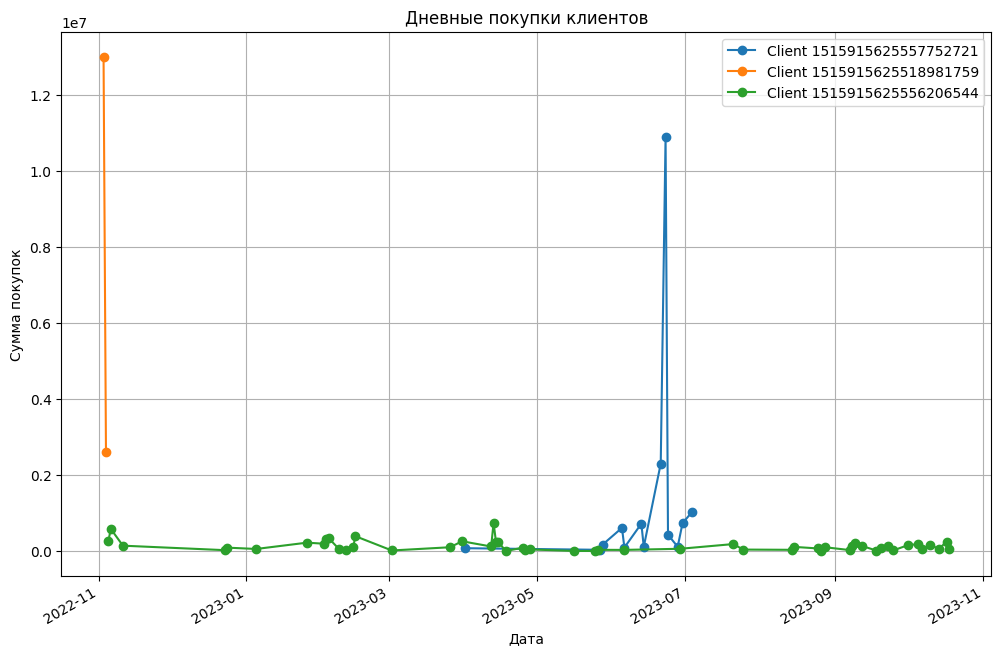

In [39]:
# клиенты для построения графиков
clients = [1515915625557752721, 1515915625518981759, 1515915625556206544]

plt.figure(figsize=(12, 8))

# построим графики для каждого клиента
for client_id in clients:
    # фильтруем данные для текущего клиента
    client_data = df_marketplace[df_marketplace['client_id'] == client_id]

    # группируем по дате
    daily_purchases = client_data.groupby('date')['total_spent'].sum()
    daily_purchases.plot(marker='o', linestyle='-', label=f'Client {client_id}')

plt.legend()
plt.title('Дневные покупки клиентов')
plt.xlabel('Дата')
plt.ylabel('Сумма покупок')
plt.grid(True)

# Показать график
plt.show()

Из трех графиков наиболее понятным кажется зеленый, это прямо идеальный постоянный клиент. Приобретает много, берет часто. График оранжевого цвета говорит нам о 2 покупках, причем в один из дней сумма достигла 12 миллионов. Синий график можно было бы признать нормальным если бы не пик в 11 миллионов. С этими значениями поработаем. А пока посмотрим еще 3 номера.

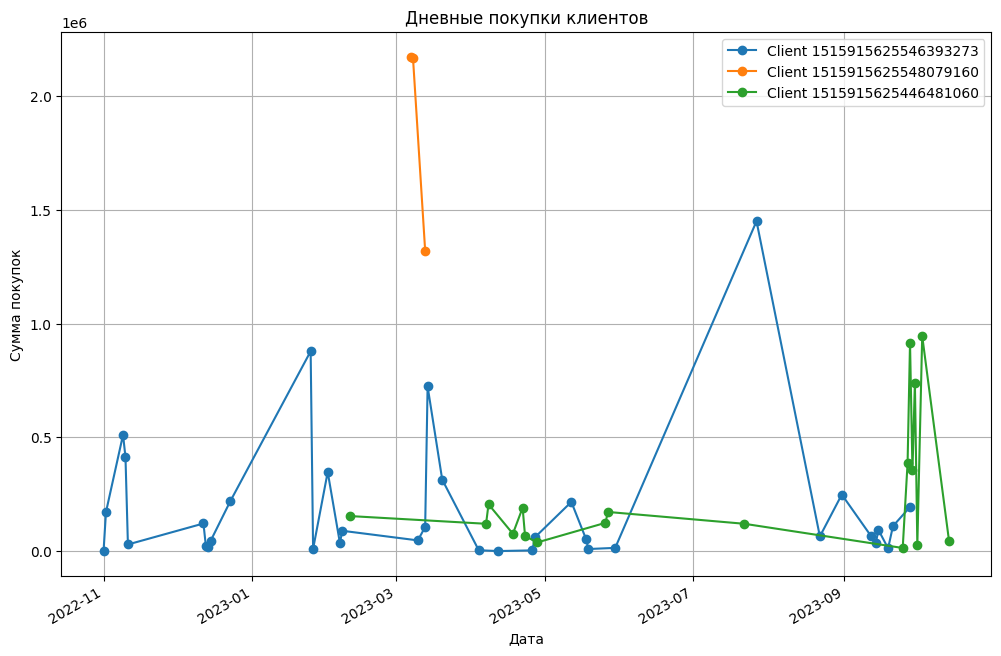

In [40]:
# клиенты для построения графиков
clients = [1515915625546393273, 1515915625548079160, 1515915625446481060]

plt.figure(figsize=(12, 8))

# построим графики для каждого клиента
for client_id in clients:
    # отфильтруем данные для текущего клиента
    client_data = df_marketplace[df_marketplace['client_id'] == client_id]
    # сгруппируем данные по дате
    daily_purchases = client_data.groupby('date')['total_spent'].sum()
    # построим график для текущего клиента
    daily_purchases.plot(marker='o', linestyle='-', label=f'Client {client_id}')


plt.legend()
plt.title('Дневные покупки клиентов')
plt.xlabel('Дата')
plt.ylabel('Сумма покупок')
plt.grid(True)

plt.show()

В данном наборе графиков синий и зеленый похожи на обычное покупательское поведение, есть правда существенные пики. И оранжевый график, из разряда загадок: пришёл потратил много денег и больше не появлялся.

Выберем самые странные графики: 1515915625557752721, 1515915625518981759, 1515915625548079160. Начнем по порядку. Отсортируем и выведем таблицу с покупками больше 2 миллионов для номера 1515915625557752721, посмотрим сколько было приобретено позиций и по какой стоимости.

In [41]:
# фильтруем данные для клиента 1515915625557752721
client_data = df_marketplace[df_marketplace['client_id'] == 1515915625557752721]

# группируем данные по дате
daily_purchases = client_data.groupby('date')['total_spent'].sum()

# фильтруем дни, когда сумма покупок превысила 2 миллиона рублей
high_purchase_days = daily_purchases[daily_purchases > 2000000].index

# выведем все покупки для этих дней
for day in high_purchase_days:
    purchases_on_day = client_data[client_data['date'] == day]
    print(f"Покупки клиента 1515915625557752721 в день {day}:")
    display(purchases_on_day)
    print()

Покупки клиента 1515915625557752721 в день 2023-06-21 00:00:00:


,client_id,quantity,price,date,total_spent,year_month,sum_month
36677,1515915625557752721,1,31998.0,2023-06-21,31998.0,2023-06,92161567.0
36678,1515915625557752721,1,59981.0,2023-06-21,59981.0,2023-06,92161567.0
36679,1515915625557752721,1,2.0,2023-06-21,2.0,2023-06,92161567.0
36680,1515915625557752721,1,85998.0,2023-06-21,85998.0,2023-06,92161567.0
36681,1515915625557752721,1,129998.0,2023-06-21,129998.0,2023-06,92161567.0
36682,1515915625557752721,1,85998.0,2023-06-21,85998.0,2023-06,92161567.0
36683,1515915625557752721,1,129998.0,2023-06-21,129998.0,2023-06,92161567.0
36684,1515915625557752721,1,85998.0,2023-06-21,85998.0,2023-06,92161567.0
36685,1515915625557752721,1,129998.0,2023-06-21,129998.0,2023-06,92161567.0
36686,1515915625557752721,1,85998.0,2023-06-21,85998.0,2023-06,92161567.0



Покупки клиента 1515915625557752721 в день 2023-06-23 00:00:00:


,client_id,quantity,price,date,total_spent,year_month,sum_month
36702,1515915625557752721,1,23998.0,2023-06-23,23998.0,2023-06,92161567.0
36703,1515915625557752721,1,85998.0,2023-06-23,85998.0,2023-06,92161567.0
36704,1515915625557752721,1,129998.0,2023-06-23,129998.0,2023-06,92161567.0
36705,1515915625557752721,1,23998.0,2023-06-23,23998.0,2023-06,92161567.0
36706,1515915625557752721,1,155555.0,2023-06-23,155555.0,2023-06,92161567.0
...,...,...,...,...,...,...,...
36867,1515915625557752721,1,219998.0,2023-06-23,219998.0,2023-06,92161567.0
36868,1515915625557752721,1,27998.0,2023-06-23,27998.0,2023-06,92161567.0
36869,1515915625557752721,1,37998.0,2023-06-23,37998.0,2023-06,92161567.0
36870,1515915625557752721,1,39998.0,2023-06-23,39998.0,2023-06,92161567.0


В данном случае имеем 2 даты. И это весьма примечательные даты 2023-06-21 и 2023-06-23. Рядом с этими датами заканчивался срок уплаты налога экспортеров, и было вероятно, что рубль ослабнет. Очень похоже на то, что конкретный клиент, предполагал такую ситуацию. По моему мнению все подобные покупки, связаны с желанием сохранить средства. Все всплески продаж приходятся на период резкого ослабления рубля. С марта по август 2023 курс доллара к рублю вырос примерно на 26%. Клиент с номером 1515915625518981759 осуществлял такие покупки перед концом 2022 года в декабре, когда курс вырос больше чем на 30%. Вполне возможно эти валютные колебания в том числе привели к части покупок магазина подарков, и, наверное, магазина одежды тоже. Но всё же это разное поведение, потому что подарки и одежду, скорее всего купят себе или в подарок партнерам, близким или друзьям, и ослабление курса просто ускорило эти покупки, а вот в маркетплейсе можно купить телевизоры, компьютеры, смартфоны и другую ликвидную технику, которая в РФ часто является способом сохранить средства.
Есть еще одна гипотеза. Такие большие закупки могут осуществлять конкуренты друг у друга. А если рассматривать одноразовые покупки с большим числом позиций в чеке и на большую сумму это может быть мошенничеством.

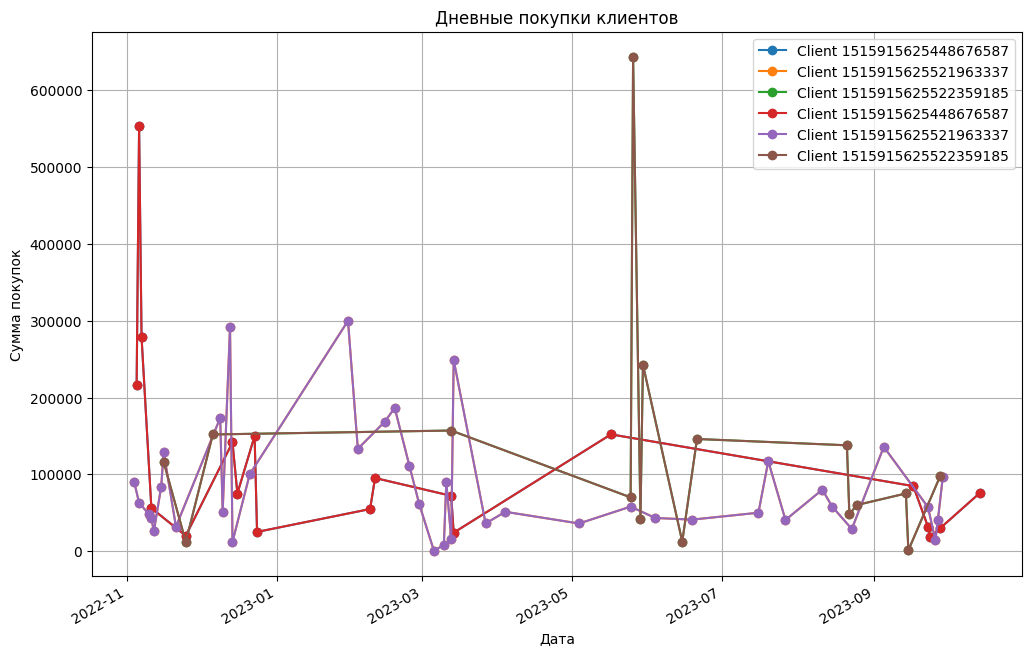

In [42]:
# клиенты для построения графиков
clients = [1515915625448676587, 1515915625521963337, 1515915625522359185, 1515915625448676587, 1515915625521963337, 1515915625522359185]

plt.figure(figsize=(12, 8))

# построим графики для каждого клиента
for client_id in clients:
    # фильтруем данные для текущего клиента
    client_data = df_marketplace[df_marketplace['client_id'] == client_id]

    # группируем данные по дате
    daily_purchases = client_data.groupby('date')['total_spent'].sum()

    # построим график для текущего клиента
    daily_purchases.plot(marker='o', linestyle='-', label=f'Client {client_id}')


plt.legend()
plt.title('Дневные покупки клиентов')
plt.xlabel('Дата')
plt.ylabel('Сумма покупок')
plt.grid(True)

plt.show()

По всей видимости мы нашли возможные причины аномального поведения покупателей. Чтобы минимизировать влияние таких крупных покупок, мы удалим их из датафрейма. В данном случае удалим все строки из нашего первоначального списка, однако отметим, что в этом списке есть 3 типа клиентов:
- новые покупатели, которые явно были спровоцированы на покупки событиями с курсом рубля и совершили крупные одноразовые покупки;
- клиенты, которые являются постоянными, но в даты падения курса совершили аномально большое число покупок;
- клиенты, которые всегда берут много в течении года, и поэтому суммарно, потратили очень много денег. Нужно выделять всех клиентов, с такими расходами в отдельную группу и придумывать для них способы удержания, если это необходимо (или задержания :=)) так как мы видим, что 3 клиента из общего анализируемого нами списка, с лета 2023 года больше не покупали в магазине.  
Таким образом мы должны будем вручную предпринять маркетинговые или другие действия в отношении данных клиентов.

## 3.6 Удаление аномалий

In [43]:
# список client_id, которые нужно удалить
clients_to_remove = [1515915625803892965, 1515915625803894158, 1515915625824280360, 1515915625855755713, 1515915625858800593, 1515915625984601209]

# удалим записи с указанными client_id
df_gifts = df_gifts[~df_gifts['client_id'].isin(clients_to_remove)]


# список client_id, которые нужно удалить
clients_to_remove = [1515915625490352441, 151591562550023210, 1515915625557342756, 1515915625580548703, 1515915625581786063, 1515915625589682336, 1515915625590690250,
                    1515915625776653984, 1515915625853312319, 1515915625860624470, 1515915625959777467]
# удалим записи с указанными client_id
df_apparel = df_apparel[~df_apparel['client_id'].isin(clients_to_remove)]

# список client_id, которые нужно удалить
clients_to_remove = [1515915625446481060, 1515915625448676587, 1515915625518981759, 1515915625521963337, 1515915625522359185, 1515915625546197123,
                     1515915625546393273, 1515915625548079160, 1515915625548888939, 1515915625555423067, 1515915625556206544,	1515915625557752721]
# удалим записи с указанными client_id
df_marketplace = df_marketplace[~df_marketplace['client_id'].isin(clients_to_remove)]

## 3.7 Создание целевого признака

Целевой признак для нас — это покупка клиентом товара в интернет-магазине в течении окна прогноза. Продолжительность окна 30 дней. Таким образом наш положительный класс такой: 1 - клиент купит в течении последних 30 дней в периоде данных; 0 - не купит.

### 3.7.1 Магазин подарков


Начнем с магазина подарков. Поскольку датафрейм маленький хочется понять сколько положительных строк будет в таргете.

In [44]:
# создадим копию исходного датафрейма
df_gifts_copy = df_gifts.copy()

# создадим дополнительный резервный датафрейм
original_gifts = df_gifts_copy

# определим дату, от которой будем делить датафреймы
end_date = df_gifts_copy['date'].max()
start_date = end_date - timedelta(days=30)


# запишем в df_gifts, данные за период, исключая последние 30 дней
df_gifts = df_gifts_copy[df_gifts_copy['date'] < start_date].copy()

# создадим forecast_window, содержащий данные только за последние 30 дней
forecast_window = df_gifts_copy[df_gifts_copy['date'] >= start_date]

print(df_gifts.shape)
print(forecast_window.shape)

(661, 7)
(38, 7)


Всего получилось 38 записей.

Выделим целевые id и посчитаем количество событий.

In [45]:
# удалим повторяющиеся значения client_id из forecast_window
forecast_window = forecast_window.drop_duplicates(subset=['client_id']).copy()

# теперь в forecast_window остались только уникальные client_id
print(forecast_window['client_id'].count())
display(forecast_window.head())

21


,client_id,quantity,price,date,total_spent,year_month,sum_month
22,1515915625817394282,1,30931.0,2023-10-13,30931.0,2023-10,950586.0
25,1515915625835000620,1,4462.0,2023-10-16,4462.0,2023-10,950586.0
26,1515915625835001136,1,5318.0,2023-10-13,5318.0,2023-10,950586.0
27,1515915625835001905,1,13936.0,2023-10-22,13936.0,2023-10,950586.0
29,1515915625835005573,1,110556.0,2023-10-02,110556.0,2023-10,950586.0


Всего в прогнозном окне получилось 21 уникальных id.

Теперь посмотрим, есть ли пересечение клиентов в датафреймах, чтобы понять много ли повторных среди тех кто купил в прогнозное окно.

In [46]:
# получим список уникальных client_id из forecast_window
forecast_client_ids = forecast_window['client_id']

# получим список уникальных client_id из df_gifts
gifts_client_ids = df_gifts['client_id']

# найдем client_id, которые есть в обоих датафреймах
common_client_ids = set(forecast_client_ids) & set(gifts_client_ids)

print(common_client_ids)

{1515915625853335947, 1515915625902774628, 1515915625835005573}


Мы видим, что всего таких 3 id. Что это для нас означает? Модель должна будет учится на данных в которых есть информация только о 3 положительных событиях.

In [47]:
def confidence_interval_proportion(n, positive_outcomes, alpha=0.05):
    """
    Рассчитывает доверительный интервал для доли с использованием метода аппроксимации нормальным распределением.

    Аргументы:
    n (int): Общее количество наблюдений.
    positive_outcomes (int): Количество положительных исходов.
    alpha (float, optional): Уровень значимости для доверительного интервала. По умолчанию 0.05.

    Возвращает:
    tuple: Кортеж, содержащий нижнюю и верхнюю границы доверительного интервала.

    """
    # оценка доли положительных исходов
    p_hat = positive_outcomes / n

    # стандартная ошибка доли
    se = np.sqrt(p_hat * (1 - p_hat) / n)

    # Z-значение для заданного уровня доверия
    z = norm.ppf(1 - alpha / 2)

    # нижняя граница доверительного интервала
    lower_bound = p_hat - z * se

    # верхняя граница доверительного интервала
    upper_bound = p_hat + z * se

    return lower_bound, upper_bound

n = 661  # общее количество наблюдений
positive_outcomes = 3  # Количество положительных исходов

# расчет доверительного интервала для доли
lower_bound, upper_bound = confidence_interval_proportion(n, positive_outcomes)

print(f"Доверительный интервал для доли с уровнем доверия 95%: [{lower_bound:.4f}, {upper_bound:.4f}]")


Доверительный интервал для доли с уровнем доверия 95%: [-0.0006, 0.0097]


В итоге у нас недостаточно данных, чтобы с уверенностью утверждать, что доля положительных исходов отличается от нуля на уровне значимости 0.05. То есть, с вероятностью 95% доля положительных исходов может быть практически нулевой или очень небольшой.  
Посмотрим на наши 3 значения, чтобы иметь представление о данных на которых модели нужно будет учится определять положительный класс.

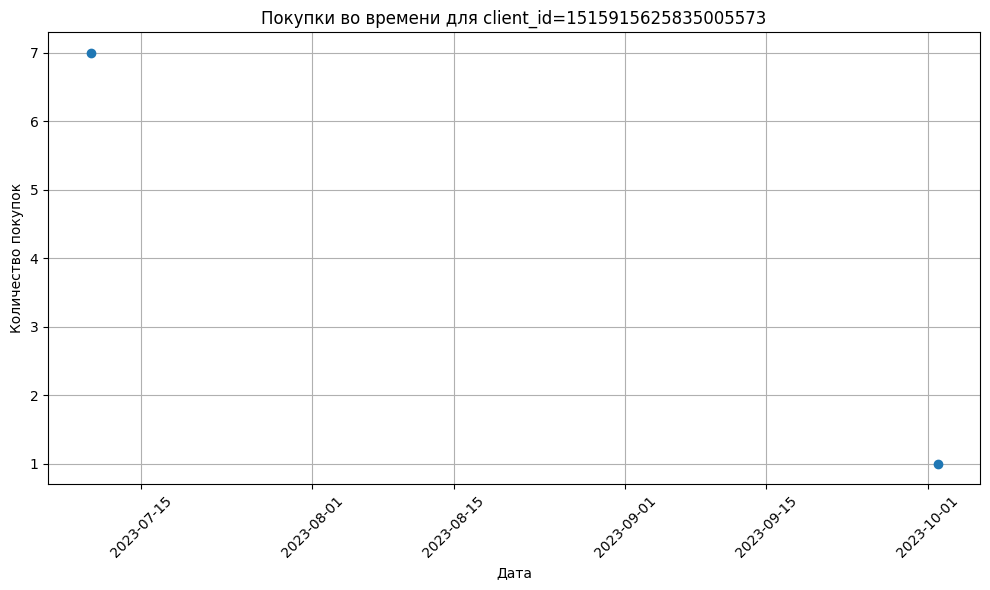

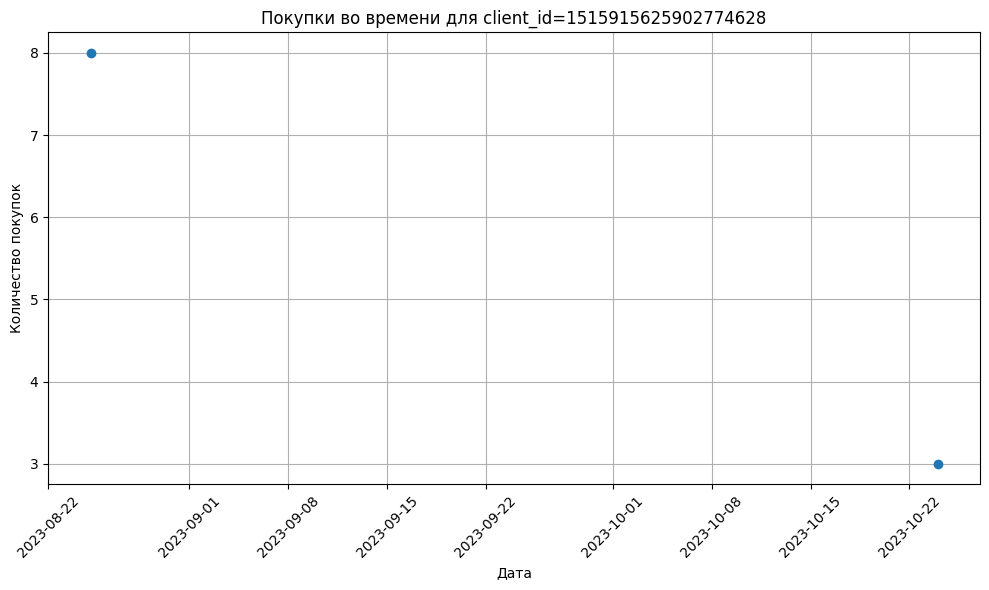

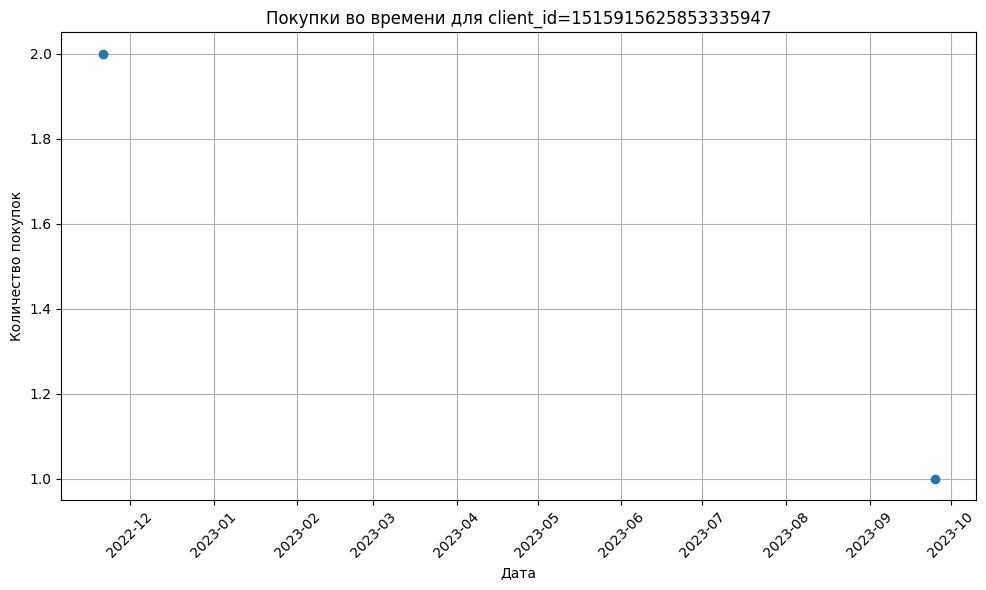

In [48]:
# выберем только определенные строки
selected_clients = [1515915625835005573, 1515915625902774628, 1515915625853335947]

# построим графики для каждого client_id отдельно
for client_id in selected_clients:

    selected_data = original_gifts[original_gifts['client_id'] == client_id]
    grouped_data = selected_data.groupby('date').size()

    plt.figure(figsize=(10, 6))
    plt.plot(grouped_data.index, grouped_data.values, marker='o', linestyle='None')
    plt.title(f'Покупки во времени для client_id={client_id}')
    plt.xlabel('Дата')
    plt.ylabel('Количество покупок')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Мы видим, что каждый из клиентов совершил покупку в диапазоне предоставленных данных 2 раза. Причем во всех случаях это было задолго до границы начала окна прогноза.
Строить модель машинного обучения с таким количеством данных бессмысленно, она не сможет с достаточной точностью указать нам нужных клиентов.  
Далее мы проведем дополнительное исследование данных, когда проведем агрегацию данных по клиентам, и после этого этапа примем решение как решить задачу прогноза для магазина подарков.

### 3.7.2 Магазин одежды и маркетплейс

Создадим промежуточный датафрейм для определения целевых id

In [49]:
def process_dataset(df):
    """
    Обрабатывает временные данные и создает два набора данных: основной набор данных для анализа и набор данных для прогнозирования.

    Аргументы:
    df (DataFrame): Датафрейм pandas с временными данными. Ожидается наличие столбца 'date' с датами.

    Возвращает:
    tuple: Кортеж, содержащий два датафрейма: основной набор данных для анализа и набор данных для прогнозирования.

    """
    df_copy = df.copy()
    df_copy['date'] = pd.to_datetime(df_copy['date'])
    end_date = df_copy['date'].max()
    start_date = end_date - timedelta(days=30)
    df = df_copy[df_copy['date'] < start_date]
    forecast_window = df_copy[df_copy['date'] >= start_date]
    return df, forecast_window

# обработка df_apparel
df_apparel, forecast_window_apparel = process_dataset(df_apparel)

# обработка df_marketplace
df_marketplace, forecast_window_marketplace = process_dataset(df_marketplace)

Разделение датафреймов осуществили, теперь оставим в окне прогноза только уникальные значения.

In [50]:
# удалим повторяющиеся значения client_id из forecast_window_apparel
forecast_window_apparel = forecast_window_apparel.drop_duplicates(subset=['client_id']).copy()

# удалим повторяющиеся значения client_id из forecast_window_marketplace
forecast_window_marketplace = forecast_window_marketplace.drop_duplicates(subset=['client_id']).copy()

print('Разделение для магазина одежды:')
print(df_apparel.shape)
print(forecast_window_apparel.shape)
print('_'*30)

print('Разделение для маркетплейса:')
print(df_marketplace.shape)
print(forecast_window_marketplace.shape)
print('_'*30)

Разделение для магазина одежды:
(128981, 7)
(821, 7)
______________________________
Разделение для маркетплейса:
(42001, 7)
(2203, 7)
______________________________


Посмотрим сколько уникальных id в положительном классе.

In [51]:
# определим forecast_client_ids для forecast_window_apparel
forecast_client_ids_apparel = forecast_window_apparel['client_id'].unique()

# определим forecast_client_ids для forecast_window_marketplace
forecast_client_ids_marketplace = forecast_window_marketplace['client_id'].unique()

apparel_client_ids = df_apparel['client_id'].unique()

marketplace_client_ids = df_marketplace['client_id'].unique()

# найдем client_id, которые есть в обоих датафреймах
common_client_ids_apparel = set(forecast_client_ids_apparel) & set(apparel_client_ids)

# найдем client_id, которые есть в обоих датафреймах
common_client_ids_marketplace = set(forecast_client_ids_marketplace) & set(marketplace_client_ids)

print('Пересечение для магазина одежды:')
print(len(common_client_ids_apparel))

print('Пересечение для маркетплейса:')
print(len(common_client_ids_marketplace))

Пересечение для магазина одежды:
159
Пересечение для маркетплейса:
500


Для таких больших датасетов данных мало.

## 3.8 Создание признаков

Мы имеем ограниченное количество исходных данных для генерации новых признаков для обучения модели. Собственно, их 3: дата, количество и цена.

Для построения прогнозной модели нам понадобятся признаки, которые будут являться производными от начальных и так или иначе будут связывать конкретного клиента и его поведение в прошлом с будущими возможными покупками.

Создадим следующие признаки:

- количество дней с момента последней покупки;
- среднее количество дней между покупками;
- количество денег, которые заплатил клиент;
- минимальная покупка;
- максимальная покупка;
- среднее количество предметов в одной покупке
- сколько покупок превышает по цене 75% квантиль;
- средняя сумма покупки в месяц.


In [52]:
# удалим ненужные колонки из каждого DataFrame
columns_to_drop = ['price', 'year_month', 'sum_month']
df_gifts.drop(columns_to_drop, axis=1, inplace=True)
df_apparel.drop(columns_to_drop, axis=1, inplace=True)
df_marketplace.drop(columns_to_drop, axis=1, inplace=True)

Проверим результат

In [53]:
# отсортируем датафрейм по id и дате
df_gifts.sort_values(by=['client_id', 'date'], inplace=True)

# создадим новый столбец, число дней между покупками
df_gifts['days_between_purchases'] = df_gifts.groupby('client_id')['date'].diff().dt.days

display(df_gifts.head())

# проверим данные в созданной колонке
unique_values = df_gifts['days_between_purchases'].unique()
print(unique_values)

,client_id,quantity,date,total_spent,days_between_purchases
540,1515915625803180506,1,2023-06-27,10972.0,NaN
541,1515915625803180506,1,2023-06-27,2450.0,0.0
542,1515915625803180506,1,2023-06-27,20539.0,0.0
214,1515915625803180756,1,2023-03-01,5990.0,NaN
543,1515915625803180771,1,2023-06-16,4824.0,NaN


[ nan   0. 155.  49.   6.  95.   1.  74.  18.  43. 108.  59.  50. 229.
   4.  73. 190.   9.  11.   3.  14.  15.  39.  10.   5.   8.]


Выполним сортировку датафреймов для корректного формирования признаков

In [54]:
df_gifts.sort_values(by=['client_id', 'date'], inplace=True)
df_apparel.sort_values(by=['client_id', 'date'], inplace=True)
df_marketplace.sort_values(by=['client_id', 'date'], inplace=True)

In [55]:
def create_new_features(df):
    """
    Создает новые признаки на основе данных о покупках клиентов.

    Аргументы:
    df (DataFrame): Датафрейм pandas с данными о покупках клиентов. Ожидается наличие столбцов 'client_id', 'date', 'total_spent'.

    Возвращает:
    DataFrame: Датафрейм pandas с новыми признаками.

    """
    # разница в днях между последовательными покупками для каждого клиента
    df['days_between_purchases'] = df.groupby('client_id')['date'].diff().dt.days
    # обработаем исключения
    df['d_btw_purchases'] = df['days_between_purchases'].replace({np.nan: -1, 0: -1})
    # сколько покупок превышает по стоимости 75% квантиль
    q75_per_client = df.groupby('client_id')['total_spent'].transform(lambda x: x.quantile(0.75))
    df['num_purchases_above_75th_quantile'] = (df['total_spent'] > q75_per_client).astype(int)
    # Средняя сумма покупки в месяц
    df['month'] = df['date'].dt.month
    df['avg_monthly_purchase'] = df.groupby(['client_id', 'month'])['total_spent'].transform('mean')
    # количество денег, которые заплатил клиент
    df['sum_pur_client'] = df.groupby('client_id')['total_spent'].transform('sum')
    # минимальная покупка
    df['min_purchase'] = df.groupby('client_id')['total_spent'].transform('min')
    # максимальная покупка
    df['max_purchase'] = df.groupby('client_id')['total_spent'].transform('max')
    # близость к концу периода в днях
    max_date = df['date'].max()
    # близость к концу периода в днях
    df['days_until_end_of_period'] = (max_date - df['date']).dt.days
    # заменим нули на 0.5
    df['days_until_end_of_period'] = df['days_until_end_of_period'].replace(0, 0.5)
    # срок жизни клиента в днях
    df['customer_lifetime_days'] = (df.groupby('client_id')['date'].transform('max') - df.groupby('client_id')['date'].transform('min')).dt.days
    # количество покупок (количество уникальных дат)
    df['num_purchases'] = df.groupby('client_id')['date'].transform('nunique')
    # удалим столбец с датой перед агрегацией
    df_for_aggregation = df.drop(columns=['days_between_purchases', 'date', 'month'])
    return df_for_aggregation

# применим функцию к датафреймам
gifts_new_features = create_new_features(df_gifts)
apparel_new_features = create_new_features(df_apparel)
marketplace_new_features = create_new_features(df_marketplace)

display(gifts_new_features.head())

,client_id,quantity,total_spent,d_btw_purchases,num_purchases_above_75th_quantile,avg_monthly_purchase,sum_pur_client,min_purchase,max_purchase,days_until_end_of_period,customer_lifetime_days,num_purchases
540,1515915625803180506,1,10972.0,-1.0,0,11320.333333,33961.0,2450.0,20539.0,88.0,0,1
541,1515915625803180506,1,2450.0,-1.0,0,11320.333333,33961.0,2450.0,20539.0,88.0,0,1
542,1515915625803180506,1,20539.0,-1.0,1,11320.333333,33961.0,2450.0,20539.0,88.0,0,1
214,1515915625803180756,1,5990.0,-1.0,0,5990.000000,5990.0,5990.0,5990.0,206.0,0,1
543,1515915625803180771,1,4824.0,-1.0,0,4824.000000,4824.0,4824.0,4824.0,99.0,0,1


Проведем агрегацию по client_id

In [56]:
def aggregate_data(df):
    """
    Агрегирует данные по клиентам.

    Аргументы:
    df (DataFrame): Датафрейм pandas с данными о покупках клиентов.

    Возвращает:
    DataFrame: Агрегированный датафрейм pandas.

    """
     # определение функций агрегации
    aggregation_functions = {
        'quantity': 'sum',
        'total_spent': 'sum',
        'num_purchases_above_75th_quantile': 'sum',
        'd_btw_purchases': 'max',
        'avg_monthly_purchase': 'first',
        'sum_pur_client': 'first',
        'min_purchase': 'first',
        'max_purchase': 'first',
        'days_until_end_of_period': 'first',
        'customer_lifetime_days': 'first',
        'num_purchases': 'first'
    }
    # проведем агрегацию данных с сохранением client_id в качестве столбца
    aggregated_data = df.groupby('client_id', as_index=False).agg(aggregation_functions)
    return aggregated_data

# применим функцию к обучающему и тестовому датафреймам
agg_df_gifts = aggregate_data(gifts_new_features)
agg_df_apparel = aggregate_data(apparel_new_features)
agg_df_marketplace = aggregate_data(marketplace_new_features)

print("Агрегированные данные для обучающего набора:")
display(agg_df_gifts.head())


Агрегированные данные для обучающего набора:


,client_id,quantity,total_spent,num_purchases_above_75th_quantile,d_btw_purchases,avg_monthly_purchase,sum_pur_client,min_purchase,max_purchase,days_until_end_of_period,customer_lifetime_days,num_purchases
0,1515915625803180506,3,33961.0,1,-1.0,11320.333333,33961.0,2450.0,20539.0,88.0,0,1
1,1515915625803180756,1,5990.0,0,-1.0,5990.000000,5990.0,5990.0,5990.0,206.0,0,1
2,1515915625803180771,1,4824.0,0,-1.0,4824.000000,4824.0,4824.0,4824.0,99.0,0,1
3,1515915625803180879,8,43152.0,2,-1.0,5394.000000,43152.0,2490.0,8990.0,86.0,0,1
4,1515915625803207150,2,5980.0,1,-1.0,2990.000000,5980.0,1990.0,3990.0,210.0,0,1


In [57]:
# проверим столбец 'd_btw_purchases' после агрегации
print("\nЗначения столбца 'd_btw_purchases' после агрегации:")
print(agg_df_gifts['d_btw_purchases'].unique())



Значения столбца 'd_btw_purchases' после агрегации:
[ -1. 155.  95.   1.  74.  18. 108.  50. 229.   4.  73. 190.  49.   9.
  11.   3.  14.  15.  39.  10.   8.]


In [58]:
agg_df_gifts.info()
agg_df_apparel.info()
agg_df_marketplace.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   client_id                          302 non-null    int64  
 1   quantity                           302 non-null    int64  
 2   total_spent                        302 non-null    float64
 3   num_purchases_above_75th_quantile  302 non-null    int64  
 4   d_btw_purchases                    302 non-null    float64
 5   avg_monthly_purchase               302 non-null    float64
 6   sum_pur_client                     302 non-null    float64
 7   min_purchase                       302 non-null    float64
 8   max_purchase                       302 non-null    float64
 9   days_until_end_of_period           302 non-null    float64
 10  customer_lifetime_days             302 non-null    int64  
 11  num_purchases                      302 non-null    int64  

## 3.9 Проверка на мультиколлинеарность

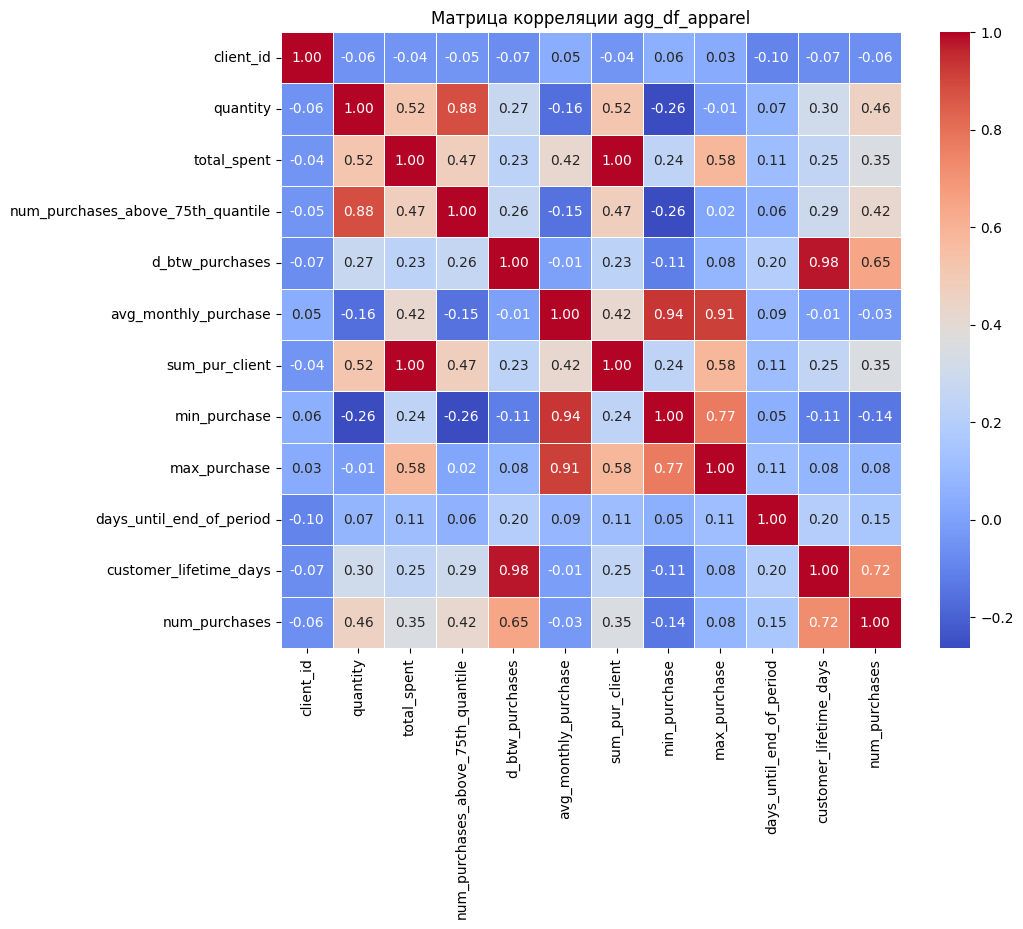

In [59]:
# создадим матрицу корреляции для agg_df_apparel
corr_matrix_apparel = agg_df_apparel.corr()

# визуализируем матрицу корреляции с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_apparel, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляции agg_df_apparel')
plt.show()

Удалим признаки, сильно коррелирующие между собой num_purchases_above_75th_quantile, sum_pur_client, customer_lifetime_days, avg_monthly_purchase

In [60]:
# список признаков для удаления
features_to_drop = ['num_purchases_above_75th_quantile', 'sum_pur_client', 'customer_lifetime_days', 'avg_monthly_purchase', 'num_purchases', 'min_purchase']

# удалим признаки из agg_df_apparel
agg_df_apparel = agg_df_apparel.drop(features_to_drop, axis=1)

display(agg_df_apparel.head())

,client_id,quantity,total_spent,d_btw_purchases,max_purchase,days_until_end_of_period
0,1515915625468061003,7,16235.0,-1.0,3499.0,264.0
1,1515915625468061170,19,33601.0,80.0,2699.0,183.0
2,1515915625468061994,8,1012.0,29.0,199.0,314.0
3,1515915625468062158,2,1398.0,-1.0,699.0,150.0
4,1515915625468062184,4,3218.0,-1.0,910.0,83.0


Проведем аналогичную работу с данными маркетплейса

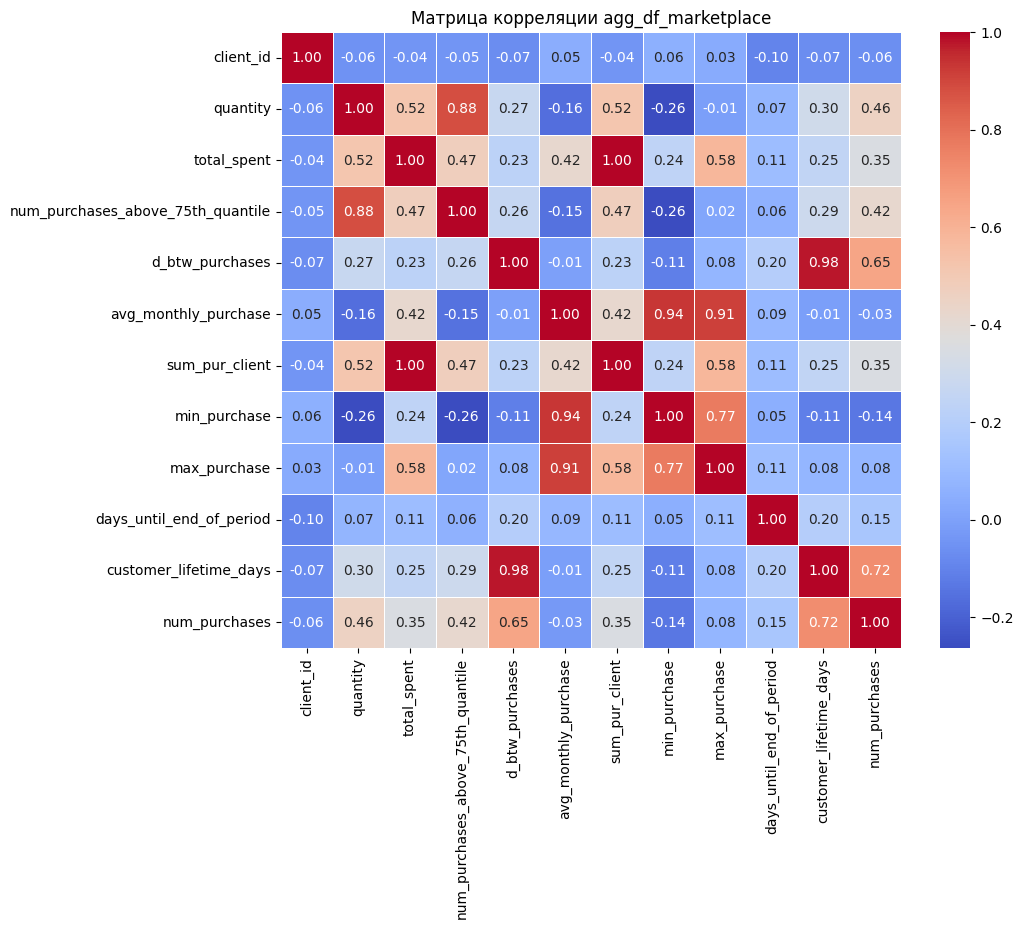

In [61]:
# создадим матрицу корреляции для agg_df_marketplace
corr_matrix_marketplace = agg_df_marketplace.corr()

# визуализируем матрицу корреляции с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_apparel, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляции agg_df_marketplace')
plt.show()

In [62]:
# cписок признаков для удаления
features_to_drop = ['num_purchases_above_75th_quantile', 'sum_pur_client', 'customer_lifetime_days', 'avg_monthly_purchase', 'num_purchases', 'min_purchase']

# удалим признаки из agg_df_apparel
agg_df_marketplace = agg_df_marketplace.drop(features_to_drop, axis=1)

display(agg_df_marketplace.head())

,client_id,quantity,total_spent,d_btw_purchases,max_purchase,days_until_end_of_period
0,1515915625440099873,2,33216.0,24.0,31998.0,71.0
1,1515915625440939402,1,75998.0,-1.0,75998.0,238.0
2,1515915625440944408,3,81178.0,62.0,73998.0,208.0
3,1515915625440947454,4,4486.0,48.0,3998.0,323.0
4,1515915625440952940,1,479.0,-1.0,479.0,318.0


Выведем проверочные матрицы

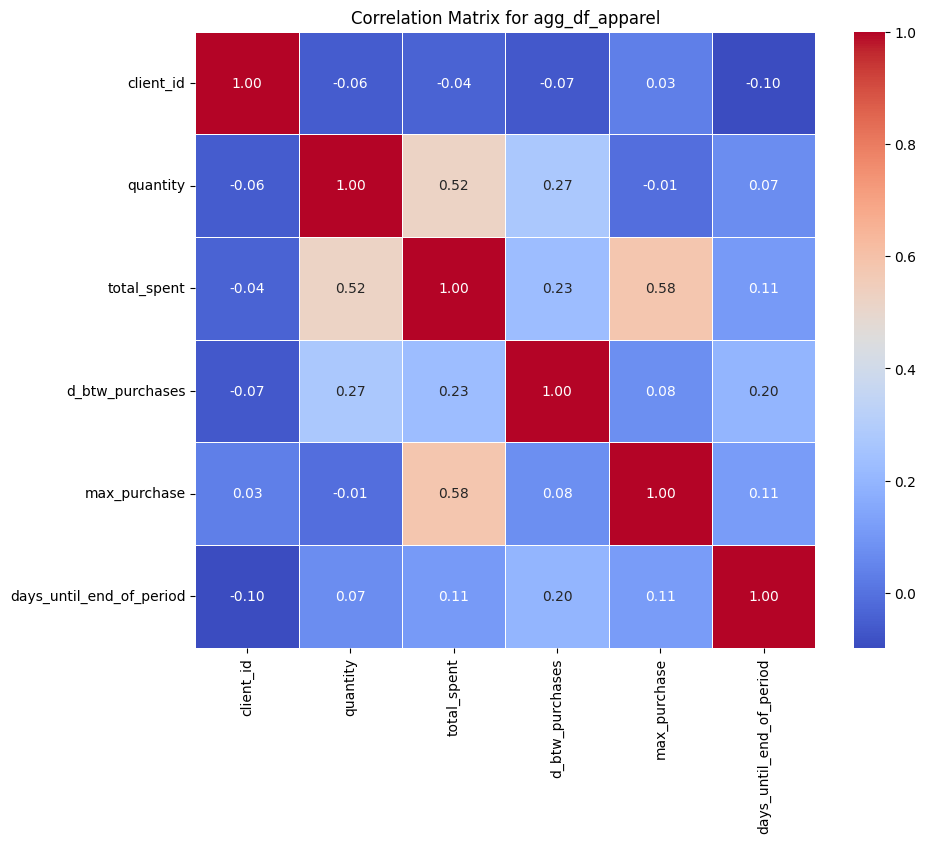

In [63]:
# создадим матрицу корреляции для agg_df_apparel
corr_matrix_apparel = agg_df_apparel.corr()

# визуализируем матрицу корреляции с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_apparel, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for agg_df_apparel')
plt.show()

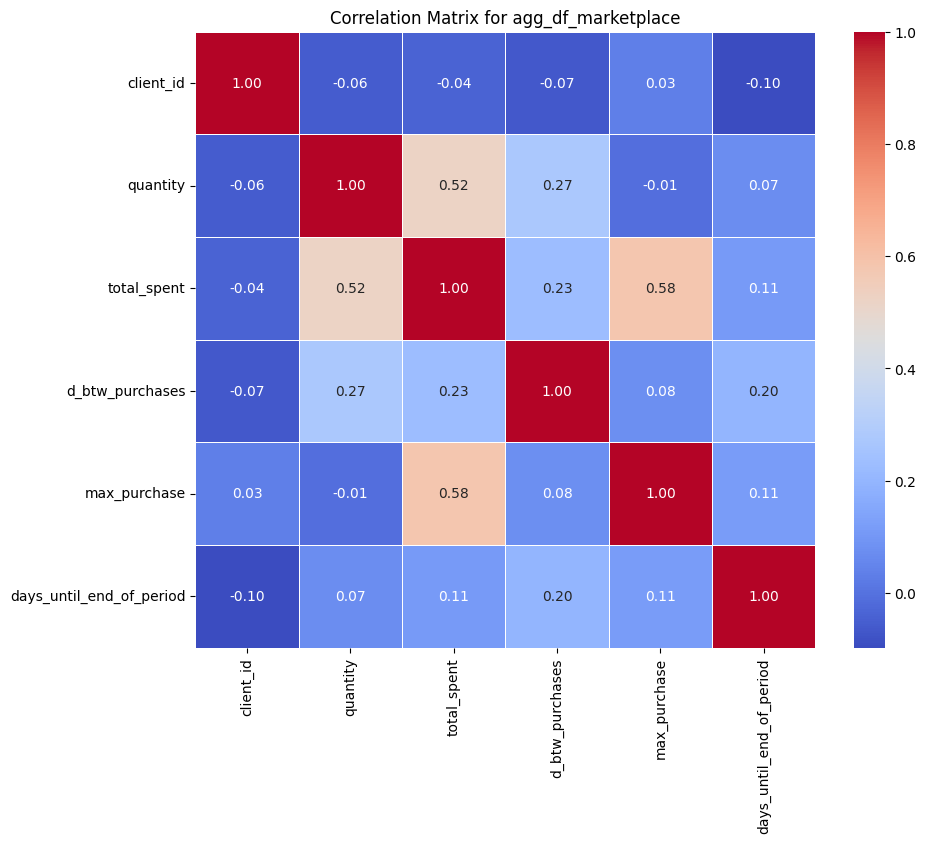

In [64]:
# создадим матрицу корреляции для agg_df_apparel
corr_matrix_marketplace = agg_df_marketplace.corr()

# визуализируем матрицу корреляции с помощью тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_apparel, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for agg_df_marketplace')
plt.show()

## 3.10 Установка целевого признака

In [65]:
def add_target_column(df, forecast_df):
    """
    Добавляет целевую переменную в датафрейм.

    Аргументы:
    df (DataFrame): Исходный датафрейм pandas.
    forecast_df (DataFrame): Датафрейм pandas, содержащий информацию о клиентах для прогнозирования.

    Возвращает:
    DataFrame: Датафрейм pandas с добавленной целевой переменной.

    """
    # установим 'client_id' в качестве индекса
    df.set_index('client_id', inplace=True)
    # создадим новый столбец 'target' и присвоим значения 1 для совпадающих пользователей и 0 для остальных
    df['target'] = df.index.isin(forecast_df['client_id']).astype(int)
    return df


# добавляем целевую колонку в каждый из DataFrame'ов
agg_df_gifts = add_target_column(agg_df_gifts, forecast_window)
agg_df_apparel = add_target_column(agg_df_apparel, forecast_window_apparel)
agg_df_marketplace = add_target_column(agg_df_marketplace, forecast_window_marketplace)

In [66]:
agg_df_gifts.info()
display(agg_df_gifts.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 1515915625803180506 to 1515915626012131867
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   quantity                           302 non-null    int64  
 1   total_spent                        302 non-null    float64
 2   num_purchases_above_75th_quantile  302 non-null    int64  
 3   d_btw_purchases                    302 non-null    float64
 4   avg_monthly_purchase               302 non-null    float64
 5   sum_pur_client                     302 non-null    float64
 6   min_purchase                       302 non-null    float64
 7   max_purchase                       302 non-null    float64
 8   days_until_end_of_period           302 non-null    float64
 9   customer_lifetime_days             302 non-null    int64  
 10  num_purchases                      302 non-null    int64  
 11  target                  

,quantity,total_spent,num_purchases_above_75th_quantile,d_btw_purchases,avg_monthly_purchase,sum_pur_client,min_purchase,max_purchase,days_until_end_of_period,customer_lifetime_days,num_purchases,target
client_id,,,,,,,,,,,,
1515915625803180506,3,33961.0,1,-1.0,11320.333333,33961.0,2450.0,20539.0,88.0,0,1,0
1515915625803180756,1,5990.0,0,-1.0,5990.000000,5990.0,5990.0,5990.0,206.0,0,1,0
1515915625803180771,1,4824.0,0,-1.0,4824.000000,4824.0,4824.0,4824.0,99.0,0,1,0
1515915625803180879,8,43152.0,2,-1.0,5394.000000,43152.0,2490.0,8990.0,86.0,0,1,0
1515915625803207150,2,5980.0,1,-1.0,2990.000000,5980.0,1990.0,3990.0,210.0,0,1,0


## 3.11 Исследование баланса классов


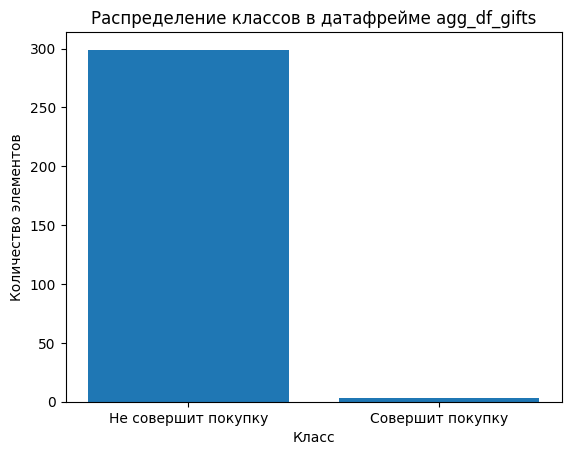

Пропорция не совершит/совершит покупку: 99.01/0.99


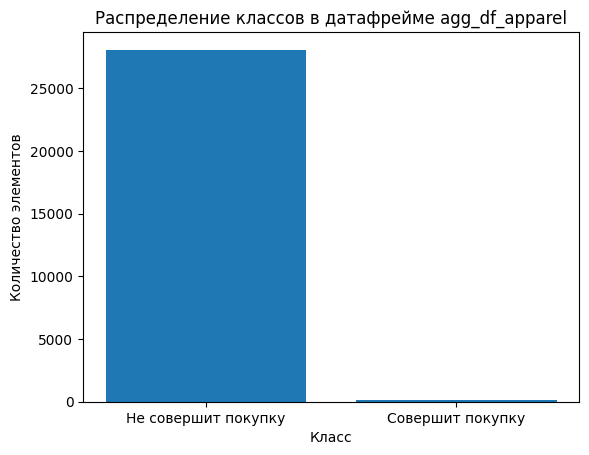

Пропорция не совершит/совершит покупку: 99.44/0.56


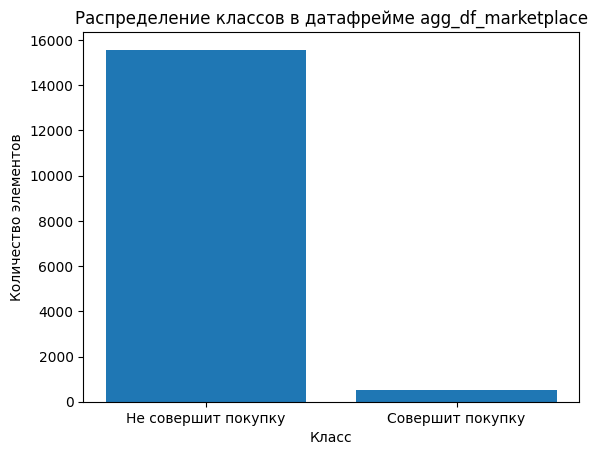

Пропорция не совершит/совершит покупку: 96.89/3.11


In [67]:
def plot_class_distribution(df, title):
    """
    Строит гистограмму распределения классов.

    Аргументы:
    df (DataFrame): Датафрейм pandas с данными, включая целевую переменную.
    title (str): Заголовок для гистограммы.

    """
    # подсчитаем количество элементов в каждом классе
    class_counts = df['target'].value_counts()

    # проведем расчет пропорции классов
    ratio_not_buying = (class_counts[0] / class_counts.sum())*100
    ratio_buying = (class_counts[1] / class_counts.sum())*100

    # построим гистограмму
    plt.bar(class_counts.index, class_counts.values)


    plt.xticks([0, 1], ['Не совершит покупку', 'Совершит покупку'])
    plt.xlabel('Класс')
    plt.ylabel('Количество элементов')
    plt.title(title)
    plt.show()
    print(f'Пропорция не совершит/совершит покупку: {ratio_not_buying:.2f}/{ratio_buying:.2f}')


# построим гистограммы распределения классов для каждого датафрейма
plot_class_distribution(agg_df_gifts, 'Распределение классов в датафрейме agg_df_gifts')
plot_class_distribution(agg_df_apparel, 'Распределение классов в датафрейме agg_df_apparel')
plot_class_distribution(agg_df_marketplace, 'Распределение классов в датафрейме agg_df_marketplace')

Получили разбег соотношения для целевого признака от 0,56 до 3,11%. Это означает, что один из классов встречается в данных существенно чаще, чем другой. Значит на лицо дисбаланс классов, который окажет сильное влияние на обучение модели. Например, модель может быть смещена в сторону чаще встречающегося класса и не сможет достаточно хорошо классифицировать объекты реже встречающегося класса, именно те, которые нам и нужно указать.

## 3.12 Изучение распределения среднего времени между покупками

Поскольку мы провели агрегацию, то теперь нам доступна возможность посмотреть распределение времени между покупками. Это позволит понять как в каждом из магазинов ведут себя постоянные покупатели.

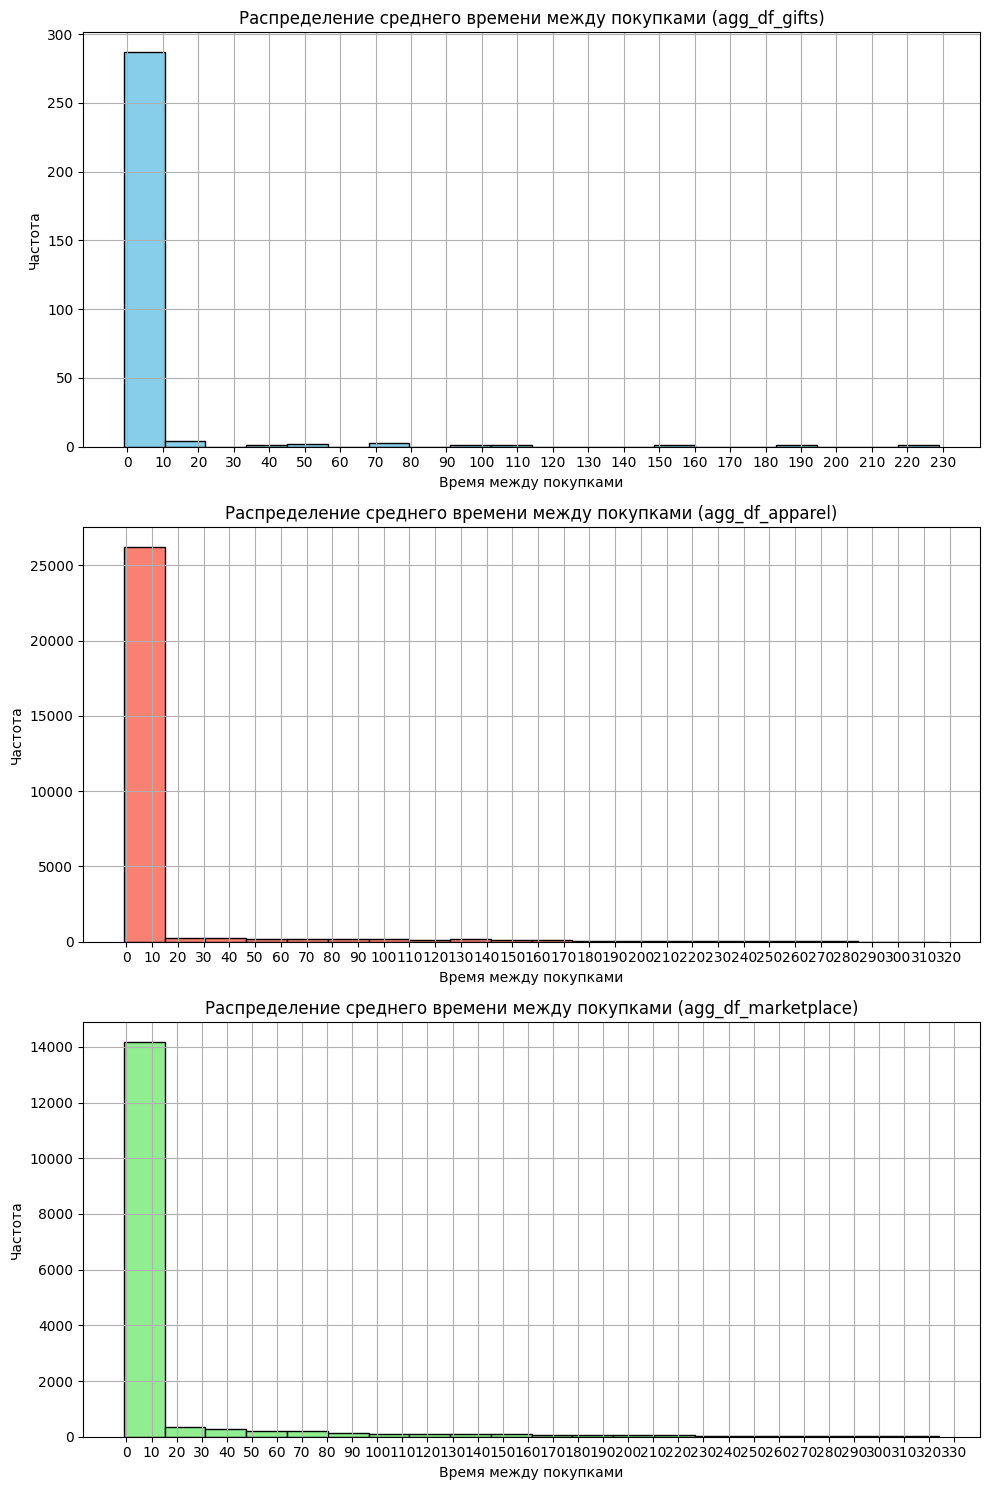

In [68]:
# список датафреймов и их соответствующих цветов для графиков
dataframes = [agg_df_gifts, agg_df_apparel, agg_df_marketplace]
colors = ['skyblue', 'salmon', 'lightgreen']
titles = ['agg_df_gifts', 'agg_df_apparel', 'agg_df_marketplace']


fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# построим гистограммы для каждого датафрейма
for i, (df, color, title) in enumerate(zip(dataframes, colors, titles)):
    axs[i].hist(df['d_btw_purchases'], bins=20, color=color, edgecolor='black')
    axs[i].set_title(f'Распределение среднего времени между покупками ({title})')
    axs[i].set_xlabel('Время между покупками')
    axs[i].set_ylabel('Частота')
    axs[i].grid(True)
    axs[i].set_xticks(range(0, int(df['d_btw_purchases'].max()) + 10, 10))

plt.tight_layout()
plt.show()


Данные графики получились не очень информативны. Большое преобладание одиночных покупок не дает хорошего представления о повторных. Создаем сокращенный вариант датафрейма чтобы убрать из данных строки, где срок между покупками равен 0. То есть клиент купил только один раз.

Повторно построим графики удалив ближайшие к нулю значения

In [69]:
# удалим строки с d_btw_purchases = 1 из agg_df_gifts
agg_df_gifts_without = agg_df_gifts[agg_df_gifts['d_btw_purchases'] != -1]

# удалим строки с d_btw_purchases = 1 из agg_df_apparel
agg_df_apparel_without = agg_df_apparel[agg_df_apparel['d_btw_purchases'] != -1]

# удалим строки с d_btw_purchases = 1 из agg_df_marketplace
agg_df_marketplace_without = agg_df_marketplace[agg_df_marketplace['d_btw_purchases'] != -1]

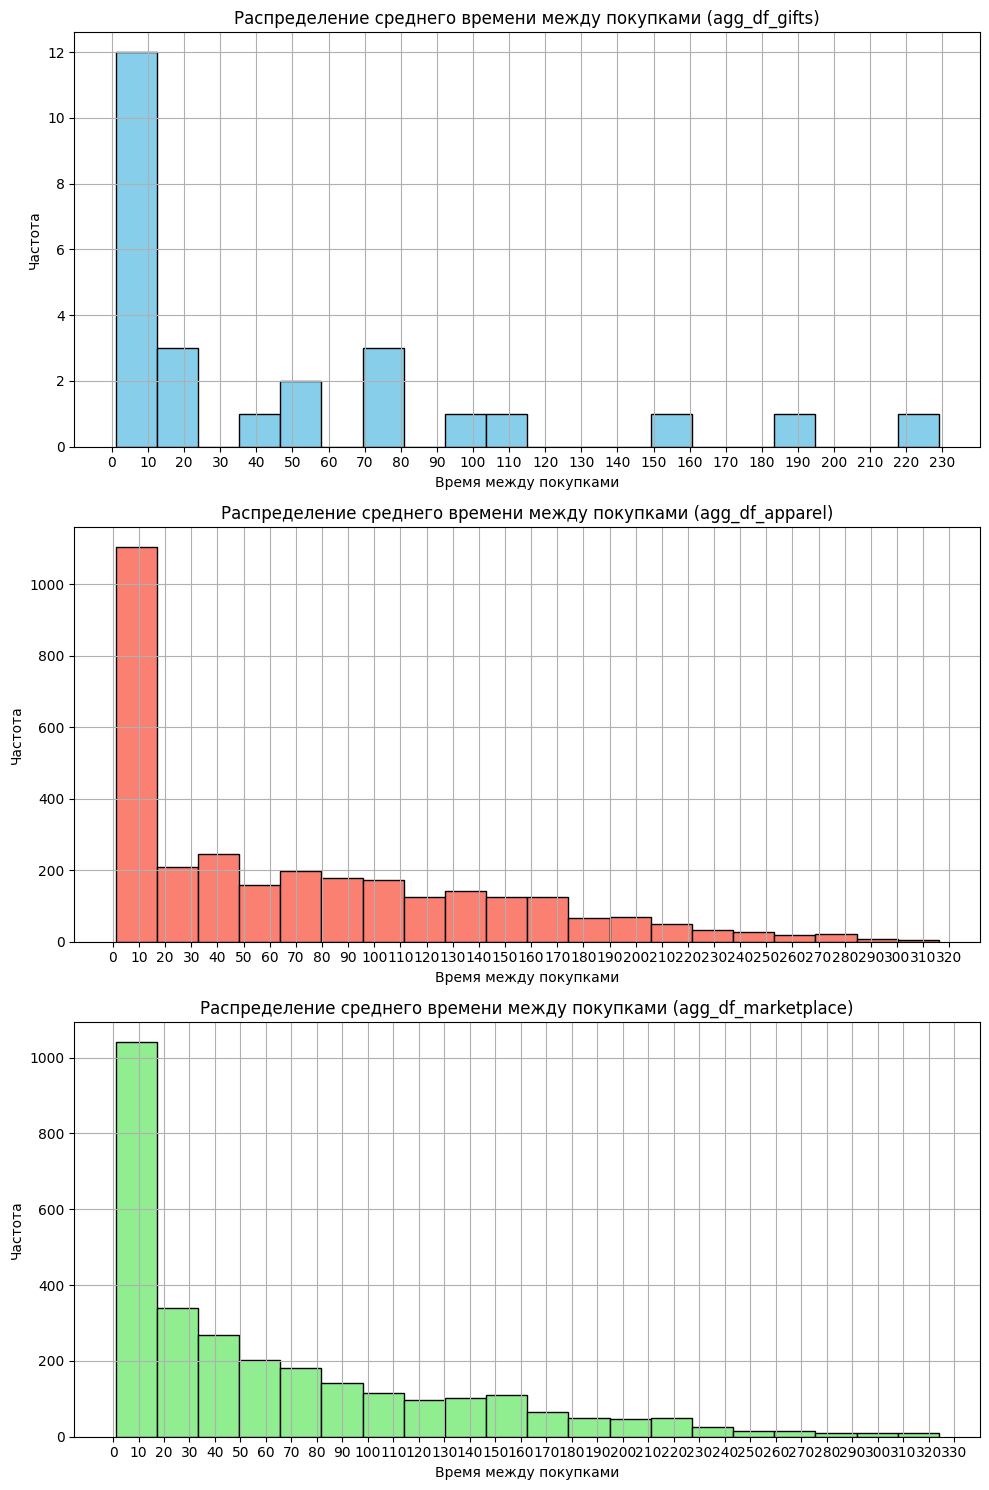

In [70]:
# список датафреймов и их соответствующих цветов для графиков
dataframes = [agg_df_gifts_without, agg_df_apparel_without, agg_df_marketplace_without]
colors = ['skyblue', 'salmon', 'lightgreen']
titles = ['agg_df_gifts', 'agg_df_apparel', 'agg_df_marketplace']


fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# построим гистограммы для каждого датафрейма
for i, (df, color, title) in enumerate(zip(dataframes, colors, titles)):
    axs[i].hist(df['d_btw_purchases'], bins=20, color=color, edgecolor='black')
    axs[i].set_title(f'Распределение среднего времени между покупками ({title})')
    axs[i].set_xlabel('Время между покупками')
    axs[i].set_ylabel('Частота')
    axs[i].grid(True)
    axs[i].set_xticks(range(0, int(df['d_btw_purchases'].max()) + 10, 10))

plt.tight_layout()
plt.show()

Постоянные покупатели в магазине одежды и маркетплейсе заполняют всю продолжительность года, а в магазине подарков можно выделить 3 сегмента:
- до 30 дней
- период 30 - 120 дней
- период 150-230.

Мы изучили особенности данных в датасете магазина подарков. Выяснили что по количеству данных он существенно отличается в меньшую сторону от двух других. Выявили что положительный класс представлен в данных единичными случаями. Обратили внимание на отличие в поведении покупателей с точки зрения повторных покупок. По совокупности данных принимаем решение составить простой логический подход для прогноза потенциальных клиентов, которые совершат покупки ближайшие тридцать дней.

## 3.13 Алгоритм предсказания покупателей для магазина подарков

Подход будем основывать на нескольких простых гипотезах:
1. Для того чтобы приобретать товары, необходимы деньги, поэтому в первое условие мы возьмем наиболее массовое число клиентов, тех кто приобретали товары стоимостью между 25 и 75 процентилями (межквартильным диапазоном). Их можно охарактеризовать как сегмент клиентов среднего уровня трат, для данного магазина. Таким образом мы отсечем тех кто платит мало и даже если мы ошиблись то магазин не много потеряет, и тех кто платит очень много, а это сегмент где необходимо участие менеджеров в ручном режиме, это мы обсуждали ранее.
2. Вторым условием возьмем особенность приобретать в один день несколько товаров, это характеризует покупателя, помимо того как платежеспособного, но так же и человека, который имеет бОльшую вероятность покупать что-то для нескольких близких.
3. Поскольку праздники имеют годовую цикличность, предположим, что человек будет нуждаться в приобретении подарка каждый год.



Составим код, который сделает прогноз по клиентам на период следующий за представленными данными, то есть на период с 2022-11-25 по 2023-12-25.

In [71]:
# преобразуем резервный датафрейм с датой в формат datetime
original_gifts['date'] = pd.to_datetime(original_gifts['date'])

# проведем фильтрацию данных по условиям
filtered_df = original_gifts[(original_gifts['price'].between(3878, 17938)) &
                       (original_gifts['date'] >= '2022-10-25') &
                       (original_gifts['date'] <= '2022-11-24')]

# проведем группировку данных по client_id и подсчет количества записей для каждого client_id
grouped_df = filtered_df.groupby('client_id').filter(lambda x: len(x) > 1)

# вывод client_id
client_ids = grouped_df['client_id'].unique()
print(client_ids)

[1515915625857065470 1515915625808531105 1515915625815091178
 1515915625835005143 1515915625835333726 1515915625842171837
 1515915625855454655 1515915625858752437 1515915625862783809
 1515915625866580364]


Для того чтобы приобретать товары, необходимы деньги, поэтому в первое условие мы возьмем наиболее массовое число клиентов, тех кто приобретали товары стоимостью между 25 и 75 процентилями (межквартильным диапазоном). Их можно охарактеризовать как сегмент клиентов среднего уровня трат, для данного магазина. Таким образом мы отсечем тех, кто платит мало и даже если мы ошиблись, то магазин не много потеряет, и тех, кто платит очень много, а это сегмент, где необходимо участие менеджеров в ручном режиме, это мы обсуждали ранее.
Вторым условием возьмем особенность приобретать в один день несколько товаров, это характеризует покупателя, помимо того, как платежеспособного, но также и человека, который имеет бОльшую вероятность покупать что-то для нескольких близких.


Продолжим работу над оставшимися датафреймами. Маркетплейс и магазин одежды имеют большое число пользователей и похожее поведение с точки зрения повторных покупок. Объединим эти датафреймы, это даст нашей модели больше данных для обучения и возможно лучшее качество.

Объединим датафреймы

In [72]:
merged_df = pd.concat([agg_df_apparel, agg_df_marketplace])
merged_df

,quantity,total_spent,d_btw_purchases,max_purchase,days_until_end_of_period,target
client_id,,,,,,
1515915625468061003,7,16235.0,-1.0,3499.0,264.0,0
1515915625468061170,19,33601.0,80.0,2699.0,183.0,0
1515915625468061994,8,1012.0,29.0,199.0,314.0,0
1515915625468062158,2,1398.0,-1.0,699.0,150.0,0
1515915625468062184,4,3218.0,-1.0,910.0,83.0,0
...,...,...,...,...,...,...
1515915625586553545,6,438988.0,-1.0,154998.0,11.0,0
1515915625586579290,2,38996.0,-1.0,25998.0,116.0,0
1515915625586588051,5,177982.0,-1.0,139996.0,96.0,0


## 3.14 Разделение на выборки

Создадим тренировочную и тестовую выборки для объединенного датафрейма


In [73]:
# разделим на обучающую и тестовую выборки (80/20)
train_df, test_df = train_test_split(merged_df, test_size=0.2,
                                    stratify=merged_df['target'], random_state=RANDOM_STATE)

x_train = train_df.drop(columns=['target'])  # признаки
y_train = train_df['target']  # целевая переменная

x_test = test_df.drop(columns=['target'])  # признаки
y_test = test_df['target']  # целевая переменная


display(x_test)
display(y_test)

,quantity,total_spent,d_btw_purchases,max_purchase,days_until_end_of_period
client_id,,,,,
1515915625570225246,3,149994.0,7.0,65998.0,206.0
1515915625491789027,4,3043.0,-1.0,1539.0,317.0
1515915625517150362,2,68396.0,-1.0,50398.0,47.0
1515915625535329844,6,437988.0,-1.0,119998.0,73.0
1515915625587553712,1,1499.0,-1.0,1499.0,241.0
...,...,...,...,...,...
1515915625553204997,1,10598.0,-1.0,10598.0,173.0
1515915625494567996,22,28334.0,1.0,2772.0,104.0
1515915625532874903,2,15136.0,104.0,13998.0,324.0


client_id
1515915625570225246    1
1515915625491789027    0
1515915625517150362    0
1515915625535329844    0
1515915625587553712    0
                      ..
1515915625553204997    0
1515915625494567996    0
1515915625532874903    0
1515915625489822752    0
1515915625780993285    0
Name: target, Length: 8858, dtype: int64

In [74]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(35432, 5)
(35432,)
(8858, 5)
(8858,)


## 3.15 SMOTE

Так как в наших данных присутствует очень большой дисбаланс, то нам необходимо применять способы его устранения. Простой upsampling не позволит нам дальше воспользоваться кроссвалидацией, поэтому попробуем использовать технику создания синтетических данных SMOTE.

In [75]:
# выведем количество примеров каждого класса до применения SMOTE
print("Количество примеров каждого класса в y_train до SMOTE:", Counter(y_train))

Количество примеров каждого класса в y_train до SMOTE: Counter({0: 34905, 1: 527})


In [76]:
# сохраним индексы
real_indices = x_train.index

# создадим экземпляр SMOTE с нужными параметрами
smote = SMOTE(sampling_strategy='auto', random_state=RANDOM_STATE)

# применим SMOTE к тренировочным данным
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# восстановим индексы и присвоим новым синтетическим данным коды
max_real_index = max(real_indices)
synthetic_indices = range(max_real_index + 1, max_real_index + 1 + len(x_train_resampled))
x_train_resampled.index = synthetic_indices

print("Диапазон индексов для x_train после применения SMOTE:", x_train_resampled.index.min(), "-", x_train_resampled.index.max())

Диапазон индексов для x_train после применения SMOTE: 1515915625995459612 - 1515915625995529421


In [77]:
# выведем количество примеров каждого класса после применения SMOTE
print("Количество примеров каждого класса в y_train после SMOTE:", Counter(y_train_resampled))

Количество примеров каждого класса в y_train после SMOTE: Counter({0: 34905, 1: 34905})


## 3.16 Масштабирование признаков

In [78]:
# создадим экземпляр класса MinMaxScaler
scaler = MinMaxScaler()

# обучим scaler и примененим масштабирования к данным
scaler.fit(x_train_resampled)
x_train_final = pd.DataFrame(scaler.transform(x_train_resampled), columns=x_train_resampled.columns, index=x_train_resampled.index)
x_test_final = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns, index=x_test.index)

print("Масштабированные данные для обучающего набора:")
display(x_train_final.head())
print("Размер первого датафрейма:", x_train_final.shape)

print("\nМасштабированные данные для тестового набора:")
display(x_test_final.head())
print("Размер второго датафрейма:", x_test_final.shape)


Масштабированные данные для обучающего набора:


,quantity,total_spent,d_btw_purchases,max_purchase,days_until_end_of_period
1515915625995459612,0.041401,0.008447,0.412308,0.001064,0.847076
1515915625995459613,0.003185,0.001407,0.000000,0.000944,0.262369
1515915625995459614,0.009554,0.014493,0.000000,0.006319,0.748126
1515915625995459615,0.003185,0.002961,0.000000,0.001987,0.817091
1515915625995459616,0.003185,0.001851,0.000000,0.001242,0.916042


Размер первого датафрейма: (69810, 5)

Масштабированные данные для тестового набора:


,quantity,total_spent,d_btw_purchases,max_purchase,days_until_end_of_period
client_id,,,,,
1515915625570225246,0.006369,0.079363,0.024615,0.046877,0.616192
1515915625491789027,0.009554,0.001610,0.000000,0.001092,0.949025
1515915625517150362,0.003185,0.036189,0.000000,0.035797,0.139430
1515915625535329844,0.015924,0.231743,0.000000,0.085233,0.217391
1515915625587553712,0.000000,0.000793,0.000000,0.001064,0.721139


Размер второго датафрейма: (8858, 5)


# 4. Реализация проекта. Часть 2, обучение модели

## 4.1 Выбор ML Модели

Поскольку разнообразие наших данных очень невелико и производные от наших данных просты, а задача стоящая перед нами предсказывать класс клиента 1 - купит, 0 не купит, то мы начнем поиск с простых моделей. Для такой задачи хорошо подходит логистическая регрессия, которая часто используется для задач бинарной классификации. А также для сравнения с ней мы будем обучать случайный лес и градиентный бустинг. На кросс-валидации мы сравним их производительность и выберем наиболее подходящий для нас вариант.

## 4.2 Обучение модели

Сначала обучаем модель на тренировочных данных и настраиваем ее параметры на кросс-валидации для выбора лучшей модели и параметров. Затем оцениваем лучшую модель на тестовых данных, чтобы оценить ее производительность на независимом наборе данных.

In [79]:
# зафиксируем данные на обучающий и тестовый наборы
x_train = x_train_final
x_test = x_test_final
y_train = y_train_resampled
y_test =  y_test

# создадим список моделей с выбранными гиперпараметрами и параметрами для GridSearchCV
models = [
    ('Logistic Regression', LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE), {'C': [0.001, 0.01, 0.1, 1, 10], 'solver': ['liblinear', 'saga']}),
    ('Random Forest', RandomForestClassifier(random_state=RANDOM_STATE), {'n_estimators': [50, 100, 200, 400], 'max_depth': [5, 10, 20]}),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=RANDOM_STATE), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.5]})
]

# создадим пустой DataFrame для хранения результатов
results = pd.DataFrame(columns=['Model', 'ROC-AUC', 'F1-score'])

# обучим и оценим каждую модель с помощью GridSearchCV
best_model = None
best_roc_auc = 0
best_f1 = 0

for name, model, param_grid in models:
    # создадим экземпляр объекта GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
    # обучим модель
    grid_search.fit(x_train, y_train)
    # получим лучшие параметры модели
    best_params = grid_search.best_params_
    # получим лучшую модель
    current_best_model = grid_search.best_estimator_
    # Оценим модель по метрикам ROC-AUC и F1-score
    mean_roc_auc = grid_search.best_score_
    y_pred = grid_search.predict(x_train)
    f1 = f1_score(y_train, y_pred)
    # добавим результаты в DataFrame
    results = pd.concat([results, pd.DataFrame({'Model': [name], 'ROC-AUC': [mean_roc_auc], 'F1-score': [f1]})], ignore_index=True)
    # обновим лучшую модель, если текущая модель лучше предыдущих по обеим метрикам
    if mean_roc_auc > best_roc_auc and f1 > best_f1:
        best_model = current_best_model
        best_roc_auc = mean_roc_auc
        best_f1 = f1

print("Результаты оценки разных моделей:")
print(results)

Результаты оценки разных моделей:
                 Model   ROC-AUC  F1-score
0  Logistic Regression  0.772135  0.702525
1        Random Forest  0.989565  0.989472
2    Gradient Boosting  0.971786  0.930934


## 4.3 Тестирование модели

На основе получившихся результатов перейдем к следующему шагу оценке лучшей модели на тестовых данных

Первый блок кода оценивает модель, предсказывая метки классов на тестовых данных (y_pred = best_model.predict(x_test)) и вычисляя различные метрики качества, такие как F1-score, Precision, Recall и ROC-AUC.

Второй блок кода оценивает модель, предсказывая вероятности принадлежности к положительному классу (y_pred_prob = best_model.predict_proba(x_test_a)[:, 1]), применяя порог для определения класса и затем вычисляя метрики качества, основанные на этих вероятностях.
А также во втором блоке мы зашили возможность вручную контролировать пороговое значение для классификации объектов и, таким образом, управлять балансом между Precision и Recall.

In [80]:
# проведем оценку лучшей модели на тестовых данных
if best_model is not None:
    # предскажем метки классов
    y_pred = best_model.predict(x_test)

    # вычислим метрики качества на основе меток классов
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # вывод по умолчанию
    print("\nЛучшая модель:", best_model)
    print("F1-score на тестовых данных:", f1)
    print("Recall на тестовых данных:", recall)
    print("ROC-AUC на тестовых данных:", roc_auc)

    # настраиваемый вывод
    print("\nНастройка вывода:")
    # вычислим вероятности принадлежности к положительному классу
    y_pred_prob = best_model.predict_proba(x_test)[:, 1]

    # различные пороговые значения для классификации объектов
    thresholds = [0.3, 0.5, 0.7]
    for threshold in thresholds:
        y_pred = (y_pred_prob > threshold).astype(int)

        # вычислим Precision и Recall для текущего порога
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        print(f"\nПорог: {threshold}")
        print("Precision на тестовых данных:", precision)
        print("Recall на тестовых данных:", recall)

        # выведем список и сохраним его в переменную
        predicted_client_ids = x_test.index[y_pred == 1]
        predicted_client_ids_list = predicted_client_ids.tolist()
        # выведем ограниченное количество client_id
        max_ids_to_display = 5
        print(f"Первые {max_ids_to_display} client_id с положительным классом:", predicted_client_ids_list[:max_ids_to_display])

        # выведем информацию о количестве элементов в списке
        print("Размер списка predicted_client_ids:", len(predicted_client_ids_list))
        # сохраним индексы в переменную
        predicted_client_ids_filtered = predicted_client_ids_list[:max_ids_to_display]

else:
    print("\nЛучшая модель не найдена.")


Лучшая модель: RandomForestClassifier(max_depth=20, n_estimators=400, random_state=12345)
F1-score на тестовых данных: 0.10582010582010581
Recall на тестовых данных: 0.30303030303030304
ROC-AUC на тестовых данных: 0.6180519381298661

Настройка вывода:

Порог: 0.3
Precision на тестовых данных: 0.05223880597014925
Recall на тестовых данных: 0.42424242424242425
Первые 5 client_id с положительным классом: [1515915625570225246, 1515915625548899090, 1515915625569100792, 1515915625536129359, 1515915625521977902]
Размер списка predicted_client_ids: 1072

Порог: 0.5
Precision на тестовых данных: 0.0641025641025641
Recall на тестовых данных: 0.30303030303030304
Первые 5 client_id с положительным классом: [1515915625521977902, 1515915625517648736, 1515915625553747393, 1515915625518652523, 1515915625539195777]
Размер списка predicted_client_ids: 624

Порог: 0.7
Precision на тестовых данных: 0.07692307692307693
Recall на тестовых данных: 0.17424242424242425
Первые 5 client_id с положительным класс

## 4.4 Предсказание client_id магазинов

После того как мы определили id клиентов необходимо их распределить на две отдельные части, для каждого магазина своя.

In [81]:
# создадим списки для каждого магазина
predicted_apparel_ids = []
predicted_marketplace_ids = []

# найдем совпадения в колонке client_id для каждого магазина
for client_id in predicted_client_ids_list:
    # проверим, есть ли client_id в df_apparel
    if df_apparel['client_id'].isin([client_id]).any():
        predicted_apparel_ids.append(client_id)
    # проверим, есть ли client_id в df_marketplace
    if df_marketplace['client_id'].isin([client_id]).any():
        predicted_marketplace_ids.append(client_id)

# выведем количество получившихся значений
print("Количество client_id с положительным классом в магазине Apparel:", len(predicted_apparel_ids))
print("Количество client_id с положительным классом в магазине Marketplace:", len(predicted_marketplace_ids))

Количество client_id с положительным классом в магазине Apparel: 69
Количество client_id с положительным классом в магазине Marketplace: 230


Использование порогового значения.  
Пороговое значение определяет границу вероятности, выше которой объект считается принадлежащим к положительному классу, а ниже - к отрицательному.
Мы можем вручную настраивать баланс между recall и precision изменяя thresholds.

Поясним как можно осуществлять данную регулировку:

Повышение порога:

Если пороговое значение повысить, например, до 0.5, то модель будет классифицировать меньше объектов как принадлежащих к положительному классу. Это может привести к увеличению точности классификации (precision), так как вероятность ложного срабатывания уменьшится, но при этом уменьшится полнота (recall), так как модель будет упускать некоторые положительные случаи.

Понижение порога:

Если пороговое значение понизить, например, до 0.3, то модель будет классифицировать больше объектов как принадлежащих к положительному классу. Это может привести к увеличению полноты (recall), так как модель будет ловить больше положительных случаев, но при этом уменьшится точность (precision), так как будет больше ложных срабатываний. В данном случае, используемые пороговые значения [0.3, 0.5, 0.7] позволяют оценить модель с разными уровнями требований к точности и полноте классификации. Пользователи должны выбирать порог в зависимости от конкретных задач и приоритетов, оптимизируя модель под свои потребности.

## 4.5 Сравнение с простейшей моделью

In [82]:
# создадим и обучим дамми модель
dummy_model = DummyClassifier(strategy="most_frequent")  # модель будет предсказывать самый частый класс
dummy_model.fit(x_train, y_train)

# предскажем вероятности классов для тестового набора данных
y_pred_proba = dummy_model.predict_proba(x_test)[:, 1]

# предскажем значения для тестового набора данных
y_pred = dummy_model.predict(x_test)

# вычислим ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# вычислим F1-меру
f1 = f1_score(y_test, y_pred)

print("ROC-AUC дамми модели:", roc_auc)
print("F1-мера дамми модели:", f1)


ROC-AUC дамми модели: 0.5
F1-мера дамми модели: 0.0


Проведем сравнение результатов модели с данными, полученными от примитивной модели (дамми модели):

ROC-AUC:

Данные обученной модели: ROC-AUC = 0.61
Данные примитивной модели (дамми модели): ROC-AUC = 0.5
Результаты показывают, что обученная модель имеет немного лучшее значение ROC-AUC по сравнению с дамми моделью. Это говорит о том, что обученная модель лучше различает между положительными и отрицательными классами, чем простая дамми модель, хотя и не сильно.

F1-мера:

Данные обученной модели: F1-score = 0.09
Данные примитивной модели (дамми модели): F1-score = 0.0
Обученная модель имеет значительно лучшее значение F1-score по сравнению с дамми моделью. Это говорит о том, что обученная модель лучше справляется с балансом между точностью и полнотой предсказаний.

Итак, обученная модель показывает некоторое улучшение по сравнению с примитивной дамми моделью, но все равно имеет недостаточное качество предсказаний для решения задачи. Требуется дополнительная работа над моделью, чтобы улучшить ее результаты.






## 4.6 Выявление наиболее значимых признаков

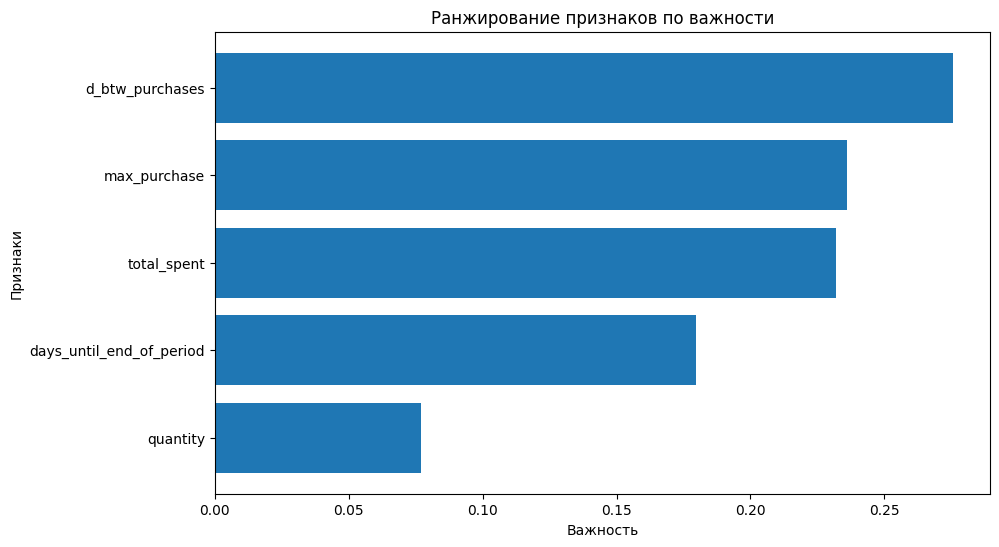

In [83]:
# получим важности признаков
feature_importances = best_model.feature_importances_

# получим названия признаков
feature_names = list(x_train.columns)

# создадим DataFrame с признаками и их важностями
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# произведем сортировку признаков по важности
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# выведем график с наиболее важными признаками
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'][:5], feature_importances_df['Importance'][:5])
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Ранжирование признаков по важности')
plt.gca().invert_yaxis()
plt.show()

Оказалось, что «средняя разница в днях между покупками» является самым значимым среди созданных признаков.
Следом идут почти в равной важности:
- «максимальная величина покупки»;
- «суммарная стоимость купленных товаров»;
Далее «расстояние в днях до окна прогноза» и «число купленных товаров». Теперь мы лучше можем понять как модель определяет кто из клиентов вероятнее всего приобретет товар.

# Вывод


Проект реализовывался в рамках сотрудничества с маркетинговым агентством, специализирующимся на веб-аналитике. Мы получили доступ к данным трех интернет-магазинов: мультикатегорийного магазина с высокой посещаемостью, магазина одежды и небольшого магазина подарков. Эти данные представляют собой анонимную историю покупок клиентов за определенный период времени.
Цель проекта заключается в разработке модели, способной предсказать, совершит ли клиент повторную покупку в течение ближайших 30 дней. Это важная задача, которая поможет интернет-магазинам оптимизировать стратегию маркетинга и удержания клиентов. Предсказание повторных покупок позволит бизнесу сфокусироваться на наиболее перспективных клиентах и принять меры для увеличения лояльности и объема продаж.
Мы провели первичный анализ предоставленных данных и в результате получили представление об особенностях интернет-магазинов.
Мы выяснили, что предсказание повторной покупки в магазине подарков может быть малоперспективной задачей. Этот магазин, вероятно, специализируется на элитных подарках, что может сильно ограничивать необходимость в повторной покупке. Об этом говорит средняя стоимость подарка, которая составляет 14468 рублей. Записей в датафрейме совсем немного, всего 811, это тоже наталкивает на мысль о сложности построения модели на них.
Магазин одежды предоставляет более обширные данные, которые, как кажется, могут обеспечить более существенную предсказательную силу. Средний чек в данном магазине составляет 1110 рублей, что кажется является небольшой суммой для одежды.
Для маркетплейса также имеются большой объем данных, на основе которых, вероятно, можно будет построить предсказательную модель.
Пропусков в данных нет, зато есть дубли. Количество их существенно отличается в разных датасетах. После их анализа сделан вывод, что повторные записи дублями не являются, а просто представляют информацию о заказе товара по той же цене, либо заказе того же товара другого цвета или размера, как например бывает при заказе одежды. Таким образом принято решение повторяющиеся строки не удалять, а объединить их по дням в одну покупку.
Для анализа предоставленных данных проведены исследования распределения среднего количества предметов в покупке, а также среднего чека и выручки магазинов. Выявлены следующие характеристики и особенности:
Магазин подарков:
- максимальный чек: высокий
- средний чек: высокий
- медианный чек: снижается, но остается высоким
- количество уникальных клиентов: невелико (326)
- обычно покупатели приобретают по одному товару, но бывают аномалии 8-12.
- выручка: 12 млн.
Наблюдается зависимость от небольшого числа клиентов. Шесть клиентов обеспечивают почти четверть выручки, что указывает на важность удержания и управление активностью этих клиентов. Требуется более глубокое изучение профиля этих клиентов для понимания их предпочтений и потребностей. Возможно, они представляют сектор корпоративных закупок или мелкооптовых клиентов. Для этих клиентов следует разработать особую стратегию взаимодействия, возможно, с предоставлением персонального менеджера или специальных предложений.
Магазин одежды:
- максимальный чек: низкий
- средний чек: низкий
- медианный чек: несущественно снижается
- количество уникальных клиентов: большое (28891)
- чаще всего приобретают 4 одинаковых предмета.
- выручка: 148 млн.
Суммы покупок в магазине одежды не очень велики, клиентов с крупными покупками мало и величины таких покупок умеренные до 232 тысяч за год. Это может свидетельствовать о том, что этот магазин имеет большое количество клиентов, каждый из которых тратит небольшие суммы. Такая ситуация кажется более устойчивой, чем в предыдущем случае.
Маркетплейс:
- максимальный чек: очень высокий
- средний чек: высокий
- медианный чек: снижается сильно, но остается высоким
- количество уникальных клиентов: среднее (17787)
- есть случаи покупки 50 одинаковых товаров, что выглядит необычно.
- выручка 1,35 млрд.
В маркетплейсе были выявлены клиенты, осуществляющие аномально крупные покупки за год. Возможные гипотезы такого поведения клиентов:
 - некоторые покупки, вероятно, связаны с изменениями валютных курсов, так как выпадают на даты ослабления курса рубля, что может быть обусловлено стратегией сохранения средств.
- конкурентные закупки или мошенничество.

Выводы:  

- интернет-магазины сильно отличаются по клиентской базе и выручке.
- средний чек также различается, но не настолько значительно, как выручка и количество клиентов.
- поскольку медианный чек показывает значительное снижение у магазина подарков и особенно у маркетплейса, делаем выводы о наличии редких, но аномально крупных покупок.
Проведено изучение графиков продаж по месяцам всех трех магазинов. Графики имеют нормальные очертания без сильных восходящих или нисходящих трендов, что говорит о стабильности их деятельности. Необходимо дополнительное исследование для выявления причин специфических моментов, таких как снижение выручки в апреле для магазина подарков и отсутствие предновогоднего бума продаж в декабре для маркетплейса. Но данные моменты не относятся к поставленной задаче напрямую, поэтому только сообщим о них заказчику.

Чтобы минимизировать влияние аномально крупных покупок на модель, мы решили удалить их из датафрейма. Однако стоит отметить, что в этом списке присутствуют разные типы клиентов:  
1. Новые покупатели, которые могли быть спровоцированы событиями, связанными с курсом валюты, и совершили крупные одноразовые покупки.
2. Постоянные клиенты, которые, возможно, реагируют на изменения курса валюты, совершая аномально большое количество покупок.
3. Клиенты, которые всегда совершают много покупок в течение года и потратили значительные суммы денег.
4. Возможные мошенники.
Необходимо выделить этих клиентов в отдельные группы и разработать стратегии работы с для каждой из них, так как это очень существенные суммы, которые могут обеспечить как высокую прибыль магазину, так и потенциальные убытки в случае реализации мошеннических схем.
После исследования мы провели предварительную обработку датасетов, включая удаление ненужных колонок и преобразование даты.
Создан целевой столбец для предсказания покупок клиентами в интернет-магазинах. Выбрано окно предсказания в 30 дней. Если у клиента в это время была покупка, то мы относим его к положительному классу и присваиваем ему значение 1 в этой строке, если покупки не было, то 0.
Проведенное исследование выявило очень сильный дисбаланс классов в целевом признаке, где один из классов встречается значительно чаще другого. Этот дисбаланс может существенно повлиять на обучение модели, поэтому мы приняли меры балансировки классов.  

Создали дополнительные признаки:  

1. Количество дней с момента последней покупки. Этот признак поможет учесть текущую активность клиента.
2. Среднее количество дней между покупками, позволит оценить среднюю периодичность покупок клиента
3. Сумма всех покупок клиента, отражает общий объем трат клиента в магазине.
4. Минимальная и максимальная суммы покупок клиента. Этот признак позволяет оценить разброс в суммах покупок клиента.
5. Среднее количество предметов в одной покупке. Отражает типичный размер покупки клиента.
6. Количество покупок, превышающих 75% квантиль цены, помогает выявить частоту дорогих покупок клиента.
7. Средняя сумма покупки в месяц
8. Максимальная покупка
9. Минимальная покупка
11. Срок жизни клиента, отчасти позволяет охарактеризовать лояльность к магазину
12. Количество покупок.  

После создания признаков проведена проверка на мультиколлинеарность. Обнаружена сильная корреляция признаков. В итоге удалены: сумма всех покупок клиента; количество покупок, превышающих 75% квантиль цены; срок жизни клиента; средняя сумма покупки в месяц.  
Поскольку данных для создания модели по магазину подарков недостаточно то вместо модели машинного обучения мы предложили использовать для решения задачи логическую модель, построенную на простых гипотезах. Мы создаем фильтр по условиям цены, количества товара и исторического периода. Код в блокноте по заданным настройкам фильтра определяет перспективных клиентов, которые должны быть наиболее подходящими кандидатами на покупку и выводит их на экран.


Логика фильтров такая:  
Первым условием для возможности приобретать товары, является наличие денег.  Поэтому в первое условие мы взяли денежную характеристику. Берем, тех кто приобретал товары стоимостью между 25 и 75 межквартильным диапазоном. Их можно охарактеризовать как сегмент клиентов среднего уровня трат, для данного магазина. Таким образом мы отсечем тех, кто платит мало и даже если мы ошиблись, то магазин не много потеряет, и тех, кто платит очень много, а это сегмент, где необходимо участие менеджеров в ручном режиме, это мы обсуждали ранее.  
Вторым условием возьмем особенность приобретать в один день несколько товаров, это характеризует покупателя, помимо того, как платежеспособного, но также и человека, который имеет бОльшую вероятность покупать что-то для нескольких близких людей.  
Третьим условием возьмем исторические данные. Поскольку праздники имеют годовую цикличность, поэтому предположим, что человек будет нуждаться в приобретении подарка каждый год, примерно в одно время.  
Мы знаем из данных, что положительный класс, то есть число клиентов, которые приобрели товары за прогнозное окно у нас составил на реальных данных 21 человек. Далее размышляем следующим образом: исходя из соотношения числа новых покупателей к старым (эту статистику можно посмотреть в любом магазине), можно примерно понять сколько клиентов должно быть предсказано из числа существующих в базе клиентов. Таким образом расширяя или сужая рамки выбранных фильтров, можно приближать число предсказанных ответов логической модели к реальности в конкретных условиях. Например, мы знаем, что в прошлом году в этом месяце было 30 покупателей, из них 20 новых, тогда мы понимаем, что идеальный прогноз должен выдать нам 10 клиентов из нашей базы. Вот к этому числу мы и должны подстроить наш прогноз. Недостатком такого прогноза можно назвать невозможность предварительной оценки, так как нам нужно заглядывать в данные годовой давности, которых мы не имеем.  

Далее мы перешли к работе над оставшимися данными. Создали тренировочную и тестовую выборки для объединенного датафрейма магазина одежды и маркетплейса. Поскольку поведение покупателей этих магазинов, схоже по периодичности покупок, то вероятно объединение данных может пойти модели на пользу. Так как мы выяснили что в наших данных присутствует очень большой дисбаланс, нам необходимо найти способ его устранения. Простой upsampling не позволил бы нам дальше воспользоваться кросс-валидацией, поэтому мы использовали технику создания синтетических данных SMOTE. Далее мы провели масштабирование признаков при помощи MinMaxScaler и на этом закончили подготовку данных к обучению.  

Создание модели.  

Задача стоящая перед нами предсказывать класс клиента 1 - купит, 0 не купит, то есть задача бинарной классификации.  
Поскольку разнообразие наших данных очень невелико и сгенерированные признаки просты, то мы использовали логистическую регрессию, а для сравнения с ней взяли случайный лес и градиентный бустинг.   
Сначала мы обучали модель на тренировочных данных и настраивали ее параметры на кросс-валидации для выбора лучшей модели и параметров.
В качестве ключевой метрики в этой работе использовали ROC-AUC которая является мерой качества модели и учитывает не только само предсказание, но и способность различать между положительными и отрицательными классами. В итоге получили следующие метрики ROC-AUC/F1:   
Logistic Regression 0.77/0.70
Random Forest 0.98/0.98
Gradient Boosting 0.97/0.93

Проверка на утечку данных не дала результата. Поэтому такие высокие величины метрик относим к переобучению. Все же техника SMOTE, хоть и создает новые данные на признаках, но данные основаны на слишком маленьком объеме исходного положительного класса.  
Затем оценили лучшую модель на тестовых данных.  
Тестирование модели осуществили в два этапа:  
- первый блок кода оценил модель, предсказывая метки классов на тестовых данных и вычисляя различные метрики качества, такие как F1-score, Precision, Recall и ROC-AUC;
- второй блок кода оценил модель, предсказывая вероятности принадлежности к положительному классу, применяя порог для определения класса и затем вычисляя метрики качества, основанные на этих вероятностях. Также во втором блоке мы добавили возможность вручную контролировать пороговое значение для классификации объектов и, таким образом, управлять балансом между Precision и Recall.  
Результаты получились такие: F1-score на тестовых данных: 0.1, что довольно низкое значение. Это означает, что модель имеет низкое сочетание точности и полноты предсказаний. Это может быть связано с тем, что модель совершает много ложноположительных и ложноотрицательных предсказаний. Recall на тестовых данных: 0.3 это означает, что модель способна обнаруживать только 30% истинных положительных случаев из всех фактических положительных случаев в тестовом наборе данных. Такое низкое значение recall указывает на то, что модель часто пропускает действительно положительные случаи. ROC-AUC на тестовых данных: 0.61 следовательно модель имеет некоторую способность различать между классами.
В заключении сравнили полученную модель с примитивной моделью, в результате выявив, что обученная модель лучше справляется с различием между положительными и отрицательными классами, а также балансирует между точностью и полнотой предсказаний.  

Так же в этой части создали краткую инструкцию по балансировке между Precision и Recall. И осуществили разделение предсказанных id клиентов покупателей по разным магазинам.  
Исходя из полученных результатов проекта, можно сделать вывод, что протестированная модель имеет недостаточное качество предсказаний для данной задачи. Вероятно, требуется дополнительное исследование и настройка модели, а также возможно, использование более сложных алгоритмов машинного обучения или более качественно проведенного процесса предобработки данных. Безусловно, различные данные, которые можно добавлять в датасет сильно добавят ей предсказательной силы. Из таких данных можно отметить информацию о товаре, например категория и наименование, а также информацию о клиенте, например, пол, возраст.










